# NOAA Data EDA

Within this notebook we explore the datasets provided by NOAA (National Oceanic and Atmospheric Administration) where we pull a total of 12 datasets across 4 different regions and aim to build a supervised learning model for predicting coral bleaching severity based on time series data.

An extended goal would be that we have would to understand the principles of an ARIMA model and attempt to build a unsupervised forecasting model to predict future bleaching patterns for coral at a global scale.

In [1]:
# Define Imports

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys

sys.path.append('..')

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore, pearsonr
from scipy.signal import correlate
from load import load_noaa_station_data
from utils import create_noaa_date_column, create_noaa_seasonal_column, convert_to_numeric

In [2]:
# NOAA dataset
# selected 4 regions with 4 stations each 
urls = [
    # Great Barrier Reef Region
    "https://coralreefwatch.noaa.gov/product/vs/data/gbr_far_northern.txt", # No stress (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/torres_strait.txt", # No stress (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/gbr_northern.txt", # No stress (Static)
    
    # Polynesia Region
    "https://coralreefwatch.noaa.gov/product/vs/data/samoas.txt", # Bleaching Watch (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/hawaii.txt", # No stress (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/southern_cook_islands.txt", # No stress (Static)
    
    # Caribbean Region
    "https://coralreefwatch.noaa.gov/product/vs/data/nicaragua.txt", # Bleaching Warning (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/panama_atlantic_east.txt", # Bleaching Warning (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/jamaica.txt", # Bleaching Warning (Static)

    # South Asia Region
    "https://coralreefwatch.noaa.gov/product/vs/data/kerala.txt", # Alert level 2 (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/eastern_sri_lanka.txt", # Bleaching Watch (Static)
    "https://coralreefwatch.noaa.gov/product/vs/data/gulf_of_kutch.txt", # Bleaching Watch (Static)
]

## Single Set Analysis

Before we pull the entire dataset, it was important for us to pull a singular subset and understand the provided columns before we began merging the sets at a large scale. 

We have already pre-defined a function under the load.py file in order to extract the data completely in its original state and in its in order to extract their data into CSV format as each regions set is provided in a txt format.

We can take the first set in the list to load and read:

In [3]:
station_df = load_noaa_station_data(urls[0])
print(station_df.head())

   YYYY  MM  DD  SST_MIN  SST_MAX SST@90th_HS SSTA@90th_HS 90th_HS>0  \
0  1985  01  01  28.8200  29.2500     29.0300       0.7797    0.5600   
1  1985  01  02  28.8000  29.3300     29.0200       0.7135    0.5500   
2  1985  01  03  28.8000  29.2700     29.0300       0.7219    0.4900   
3  1985  01  04  28.7500  29.3100     29.0300       0.7103    0.4600   
4  1985  01  05  28.7100  30.6700     29.6400       1.3177    1.0500   

  DHW_from_90th_HS>1 BAA_7day_max           Station              Region  \
0             0.0000            0  Far Northern GBR  Great Barrier Reef   
1             0.0000            0  Far Northern GBR  Great Barrier Reef   
2             0.0000            0  Far Northern GBR  Great Barrier Reef   
3             0.0000            0  Far Northern GBR  Great Barrier Reef   
4             0.0000            0  Far Northern GBR  Great Barrier Reef   

   Latitude  Longitude  
0   -12.675      144.1  
1   -12.675      144.1  
2   -12.675      144.1  
3   -12.675     

From a high-level perspective, before we get into the column details and what they mean, it is important to understand that the set contains:

- environmental condition measurements - temperatures of the sea surface (columns SST_MIN, SST_MAX, SST@90th_HS)

- temperature anomalies - how much warmer/cooler the temperatures was found to be in comparisons to averaged values(columns SSTA@90th_HS)

- bleaching risk level: An integer scale from 0 to 7 ascending in the severity of bleaching levels as can be seen by the column BAA__7day_max

Now, in order to define the space that we are working in, let us outline each column stated above as a prerequisite and it's definitions:

- YYYY, MM, DD - The year, month, and date 

- SST_MIN - The minimum sea surface temperature for a specific date

- SST_MAX - The maximum sea surface temperature for a specific date

- SST@90th_HS - The temperature at the 90th percentile for a specific date

- SSTA@90th_HS - The temperature anomaly at the 90th percentile
  - What is a SSTA (Sea Surface Temperature Anomaly)? The difference between the observed sea surface temperature (SST) and the long-term average SST for that location and time of year.
  - A positive anomaly means the water is warmer than usual, while a negative anomaly means it's cooler than usual.

- 90th_HS>0 - The daily hotspot value at the 90th percentile - how much above the bleaching threshold the temperature is

- DHW_from_90th_HS>1 - degree heating weeks - something like accumulated heat stress over the past weeks??

- BAA_7day_max


As always, we should start our EDA process with a basic null check for all column values and the datatypes so that we can get a first insight to what we are working with:

In [4]:
print(station_df.isna().sum()) 
print(station_df.dtypes)


YYYY                  0
MM                    0
DD                    0
SST_MIN               0
SST_MAX               0
SST@90th_HS           0
SSTA@90th_HS          0
90th_HS>0             0
DHW_from_90th_HS>1    0
BAA_7day_max          0
Station               0
Region                0
Latitude              0
Longitude             0
dtype: int64
YYYY                   object
MM                     object
DD                     object
SST_MIN                object
SST_MAX                object
SST@90th_HS            object
SSTA@90th_HS           object
90th_HS>0              object
DHW_from_90th_HS>1     object
BAA_7day_max           object
Station                object
Region                 object
Latitude              float64
Longitude             float64
dtype: object


We seem to face no issues with the null check as the dataset seems to show quiet consistent across. One thing that we do face as an issue though is that our numerically expected data types are of type object. Let us quickly fix this to numerical values:

In [5]:
# Define for the columns that should be converted to numeric as we know from above
numeric_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 
                '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']

station_df = convert_to_numeric(station_df, numeric_cols)

print('data types of columns: ', station_df.dtypes)

data types of columns:  YYYY                   object
MM                     object
DD                     object
SST_MIN               float64
SST_MAX               float64
SST@90th_HS           float64
SSTA@90th_HS          float64
90th_HS>0             float64
DHW_from_90th_HS>1    float64
BAA_7day_max            int64
Station                object
Region                 object
Latitude              float64
Longitude             float64
dtype: object


Now that we are working with the correct types, lets do a quick duplication check:

In [ ]:
print('duplicate rows: ',  station_df.duplicated().sum())

duplicate rows:  0


## Analysis

With the first round of data check in order, we can begin properly analysing our first dataset, there are common guidelines that we can follow during the procedure and will do the usual checks, but tailor the analysis to our needs as it's important to keep in mind that we are looking at time series data. We will follow the steps of analaysing:

- Correlations 
- Distributions
- Seasonal Analysis
- Time-series Analysis

#### Correlations

TODO: Fill

Goal: Identify relationships between variables to prioritize key predictors of bleaching severity (BAA_7day_max).

Correlation Matrix:
                     SST_MIN   SST_MAX  SST@90th_HS  SSTA@90th_HS  90th_HS>0  \
SST_MIN             1.000000  0.971277     0.962997      0.473266   0.650750   
SST_MAX             0.971277  1.000000     0.987190      0.503161   0.664225   
SST@90th_HS         0.962997  0.987190     1.000000      0.524327   0.675245   
SSTA@90th_HS        0.473266  0.503161     0.524327      1.000000   0.523250   
90th_HS>0           0.650750  0.664225     0.675245      0.523250   1.000000   
DHW_from_90th_HS>1  0.460519  0.447230     0.457287      0.366433   0.511595   
BAA_7day_max        0.692850  0.698139     0.707988      0.456726   0.847001   

                    DHW_from_90th_HS>1  BAA_7day_max  
SST_MIN                       0.460519      0.692850  
SST_MAX                       0.447230      0.698139  
SST@90th_HS                   0.457287      0.707988  
SSTA@90th_HS                  0.366433      0.456726  
90th_HS>0                     0.511595      0.847001  
DHW_from_

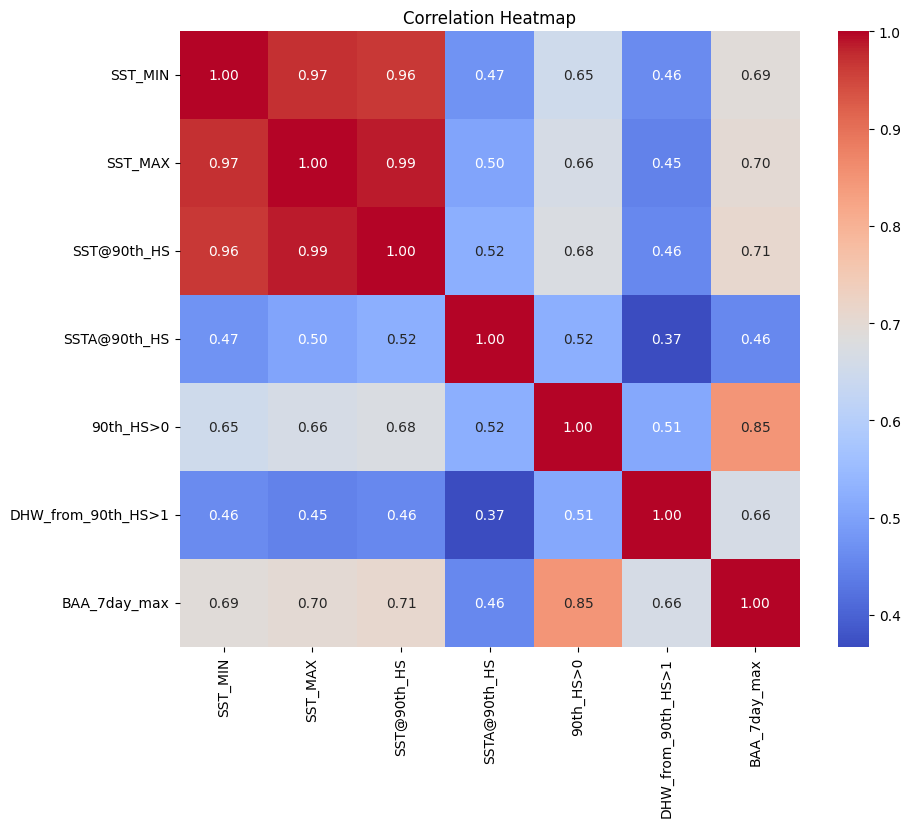

In [7]:
correlation_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']
correlation_df = station_df[correlation_cols].dropna()
correlation_matrix = correlation_df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

***Key takeaways***

- 90th_HS>0: We can see from the heatmap and the calculated results that we seem to hold very strong positive correlations between the 90th_HS>0 and the bleaching severity. If we recap to what the 90th_HS>0 column represents, the results make sense as it is the direct measure of how much the SST(sea surface temperature) exceeds the bleaching threshold. 

- SST@90th_HS

#### Distributions

No matter what set we work with, it is alway important to check distributions. The point of this step for us, is as usual, to see what sort of spread patterns are shown across the dataset. We want to know whether we are looking at any skewed or normal curves, check for outliers, and see if we can spot any patterns that may be of interest to us. 

First lets start by mapping all the distributions of each numerical value columns:

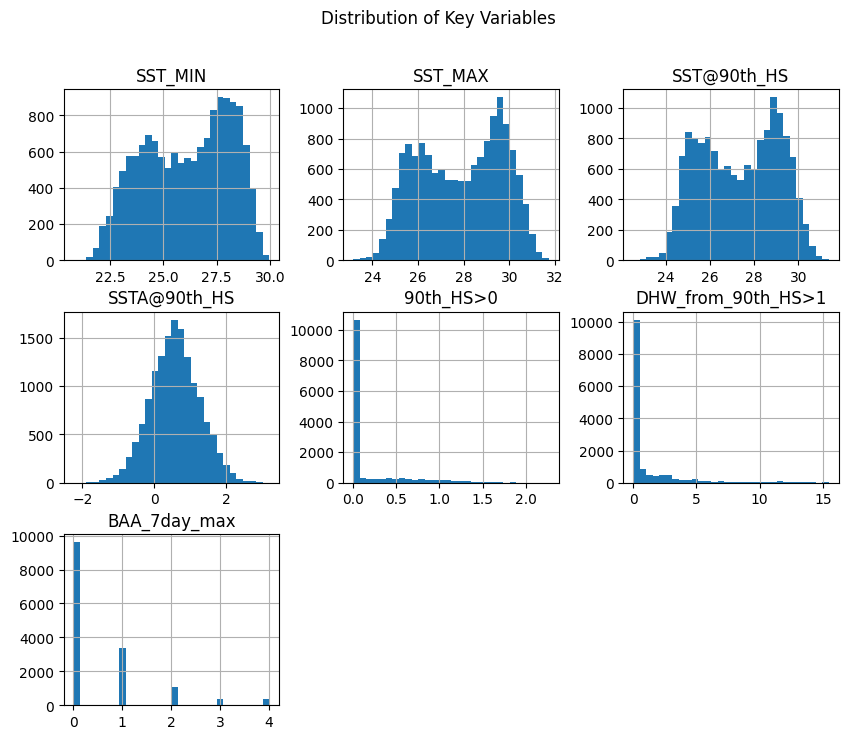

In [8]:
numeric_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']
station_df[numeric_cols].hist(bins=30, figsize=(10, 8))
plt.suptitle('Distribution of Key Variables')
plt.show()

#### Takeaways

Immediately we can take take a look at this and see incredible skews on the 90th_HS>0, and the DHW_from_90th_HS>1 which makes sense to us and as expected from the correlation analysis from earlier.

This is because the first 90th percentile (90th_HS>0) measures how much the SST (sea surface temperature) exceeds the bleaching threshold where > 0 shows above and <= 0 shows below. Most of the time, we can expect the SST to be below the bleaching threshold, so the extreme skew is no surprise.

In regards to the degree heating weeks, it measures the accumulated heat stress over the past weeks where we calculate it from the sum of daily temperature anomalies above the bleaching threshold over a rolling 12-week period. Again, coral bleaching values are rare, therefore we can expect to see many more zeroes than positive values in this columns distribution.


SST anomalies on the 90th percentile hotspot (SSTA@90th_HS) catches our attention as it seems to show us a normal distribution like bell curve. What this seems to tell us is that the temperature anomalies seem to be fairly stable and follow a predictable pattern and that they are not experiencing a lot change most of the time. This could indicate to use that we would likely want to leverage this property aswell for model training.

For the first row, we seem to see what we call bimodal distribution, meaning that we see two peaks in the distribution. As each of the three distributions are measuring the direct SST (Sea Surface Temperature) patterns, this suggests to us that this could quite likely be caused by the seasonal changes but it would be good to have a further look and confirm which we cover in our next seasonal analysis section.

Overall, the variables like 90th_HS>0 and DHW_from_90th_HS>1 are heavily skewed, indicating that extreme heat events might be rare, but the correlations map from earlier suggests to be the key indicators of symbiotic algae release.

### Seasonal Analysis

With the distributions clearly visualised, it has given us a great opportunity to make some seasonal analysis as we where clearly able to see which factors where likely to be influenced by the seasons.

For the first step, it would make sense to do a bit of feature engineering and create the seasons column for the dataset from the extracting the months and deducing values:

In [9]:
create_noaa_seasonal_column(station_df)
print(station_df['Season'].head())

0    Winter
1    Winter
2    Winter
3    Winter
4    Winter
Name: Season, dtype: object


Now that we have added the season column, lets try plotting the grouped distributions to get a first view:

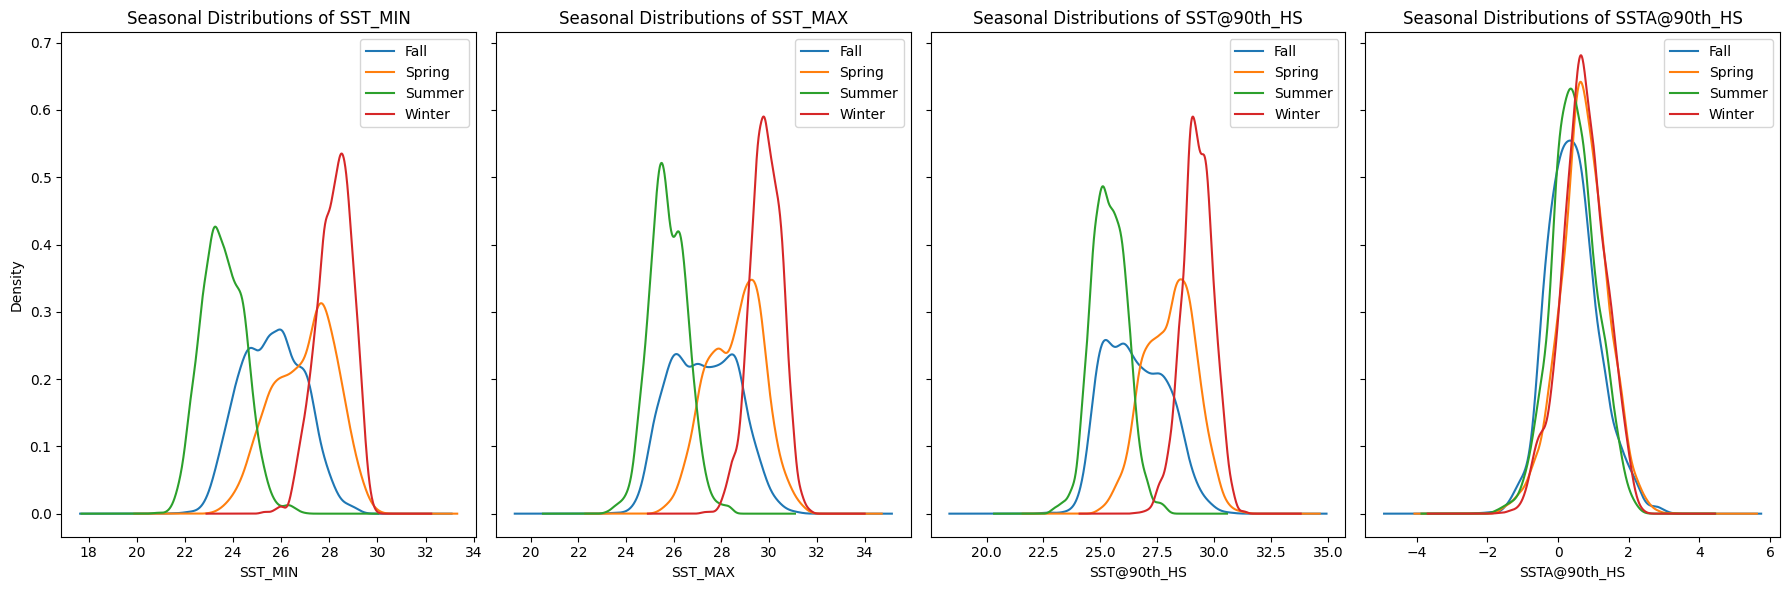

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

# For SST_MIN
station_df.groupby('Season')['SST_MIN'].plot(kind='kde', ax=axes[0], legend=True)
axes[0].set_title('Seasonal Distributions of SST_MIN')
axes[0].set_xlabel('SST_MIN')

# For SST_MAX
station_df.groupby('Season')['SST_MAX'].plot(kind='kde', ax=axes[1], legend=True)
axes[1].set_title('Seasonal Distributions of SST_MAX')
axes[1].set_xlabel('SST_MAX')

# For SST@90th_HS
station_df.groupby('Season')['SST@90th_HS'].plot(kind='kde', ax=axes[2], legend=True)
axes[2].set_title('Seasonal Distributions of SST@90th_HS')
axes[2].set_xlabel('SST@90th_HS')

# For SSTA@90th_HS
station_df.groupby('Season')['SSTA@90th_HS'].plot(kind='kde', ax=axes[3], legend=True)
axes[3].set_title('Seasonal Distributions of SSTA@90th_HS')
axes[3].set_xlabel('SSTA@90th_HS')

plt.tight_layout()
plt.show()


Very interesting indeed!

***SST minimum & maximum***

So from this, we can clearly tell that our initial intuitive guesses for the SST minimum and maximum distributions where in fact caused by the seasonal changes which is not much of a surprise, where we can see the distribution looks almost identical to our first plot that we did earlier. 

***SST Anomolies at the 90th percentil hotspot*** 

What is exciting though is that the seasonal distributions for the SSTA@90th_HS seems to show a normal distribution like bell curve as we already saw from earlier but also regardless of when we group by the season. 

***Why is this so interesting to us?***

We want to study this a bit further because it differs from the other patterns despite being centered around the SST. This made us curios as to what the anomaly could be representing and whether we where onto something.

***What does this mean?***

First of all, we need to understand that the SSTA@90th_HS is an **anomaly**, meaning it measures deviations from a long-term average for each location and time of year.

We hypothesis that the lack of seasons effect in the SSTA@90th_HS distribution tells us that the anomaly calculation, as stated above, has actually removed the seasonal factor from the data. This actually could make it a useful variable for identifying unusual temperature events that can not normally be detected, regardless of the season and tells us that we should consider this column when training our model .

#### Further investigation

From this finding, we also wanted to further investigate specifically into the SSTA@90th_HS.

Furthermore to summarise more a more practical understanding of the SSTA@90th_HS columns, we can say that when the 90th_HS increases, we are experiencing much warmer temperatures than what is expected which can ofcourse, cause for concern due to it being one of the factors involved in coral symbiotic algae release.

Since we already know we want to investigate this further, we could use some statistical skills together with intuition from the earlier statement to take a targeted focus into the upper percentile outliers for higher temperatures.

For the sake of covering both ends, let's get started and break them down for the upper and lower ranges into > 2 and < -2 as can be seen from the distribution above to cover all both the upper and lower percentile anomalies

In [11]:
upper_anomalies = station_df[station_df['SSTA@90th_HS'] > 2]
lower_anomalies = station_df[station_df['SSTA@90th_HS'] < -2]

# We use the absolute value and check > 2 for both upper and lower anomalies combined because |-2| = 2
lower_and_upper_anomalies = station_df[station_df['SSTA@90th_HS'].abs() > 2]

Alright, now that lets do a boxplot first to very easily try and spot any of the outliers, we will just do for all three so that it is easy to view in one go:

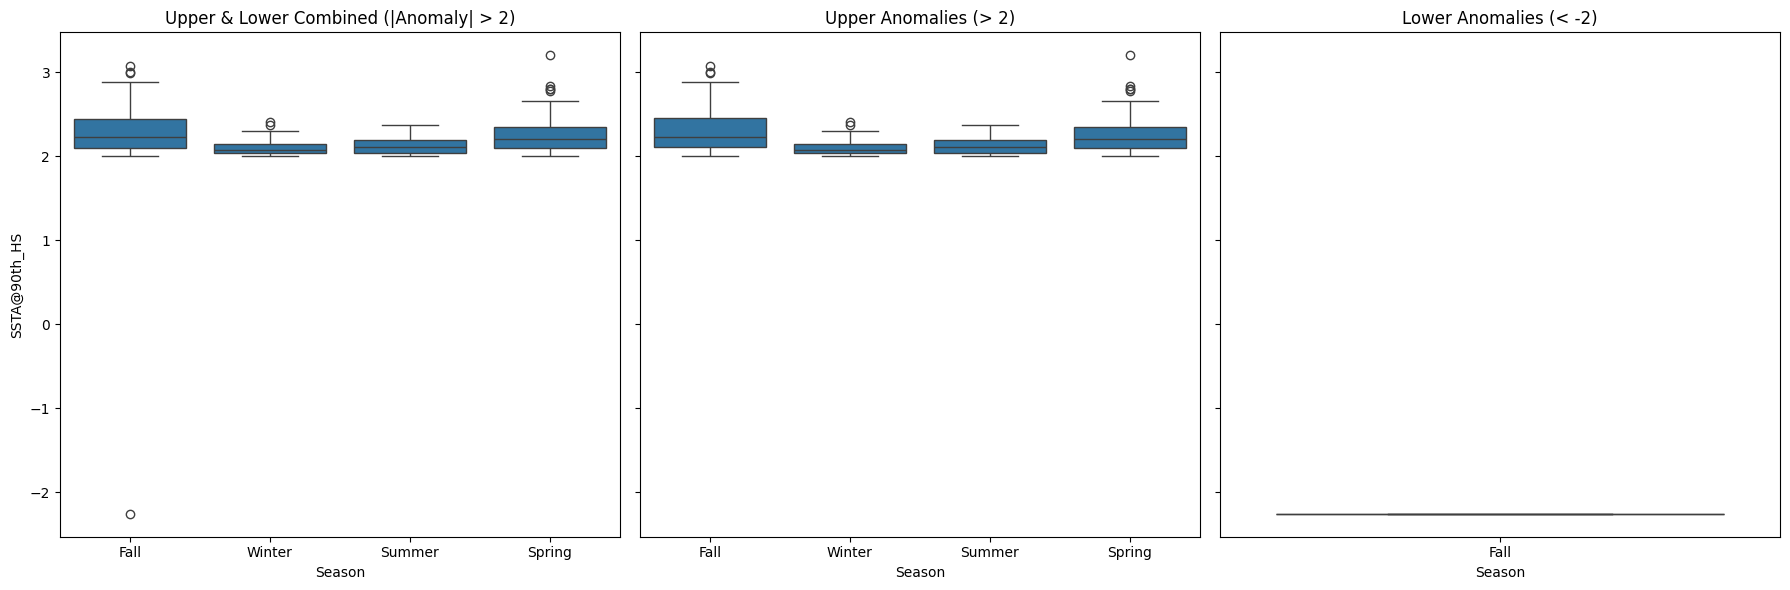

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# For Both
sns.boxplot(data=lower_and_upper_anomalies, x='Season', y='SSTA@90th_HS', ax=axes[0])
axes[0].set_title('Upper & Lower Combined (|Anomaly| > 2)')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('SSTA@90th_HS')

# For Upper only
sns.boxplot(data=upper_anomalies, x='Season', y='SSTA@90th_HS', ax=axes[1])
axes[1].set_title('Upper Anomalies (> 2)')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('')

# For lower only
sns.boxplot(data=lower_anomalies, x='Season', y='SSTA@90th_HS', ax=axes[2])
axes[2].set_title('Lower Anomalies (< -2)')
axes[2].set_xlabel('Season')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

As shown, only the upper anomalies show outliers whereas the lower anomalies show no outliers. This is great, lets focus on the upper range:

In [13]:
seasonal_stats = upper_anomalies.groupby('Season')['SSTA@90th_HS'].agg(['mean', 'quantile'])
seasonal_stats['25th Percentile'] = upper_anomalies.groupby('Season')['SSTA@90th_HS'].quantile(0.25)
seasonal_stats['75th Percentile'] = upper_anomalies.groupby('Season')['SSTA@90th_HS'].quantile(0.75)

print(seasonal_stats)

            mean  quantile  25th Percentile  75th Percentile
Season                                                      
Fall    2.314420    2.2377         2.108225         2.452175
Spring  2.269883    2.2084         2.106500         2.353550
Summer  2.126132    2.1153         2.044150         2.190425
Winter  2.116130    2.0819         2.046925         2.154000


We now have a very clear vision on the IQR (interquartile range: 75th - 25th) between the four different seasons for the SSTA and can see which season tends to introduce the largest deviation in terms of the SST anomalies. We see the ranking to show the Fall season ho9lding the largest IQR, followed by sping, summer, and winter.

*What can we learn from this?*

If what we where first hypothesing about the upper anomalies laeding to coral bleaching to be true, we can say from this that the Fall and Spring may represent higher-risk periods for coral bleaching due to their higher IQR for outliers.

Intuitively, our next steps to follow would be to try and confirm this informatio by calculating correlations and mapping them out to see if what we are saying can be true or not.

In [14]:
station_df['SSTA_Z_Score'] = zscore(station_df['SSTA@90th_HS'])

extreme_anomalies = station_df[(station_df['SSTA_Z_Score'] > 3) | (station_df['SSTA_Z_Score'] < -3)]

seasonal_z_stats = station_df.groupby('Season')['SSTA_Z_Score'].agg(['mean', 'std', 'max', 'min'])

print("Seasonal Z-Score Statistics:")
print(seasonal_z_stats)

Seasonal Z-Score Statistics:
            mean       std       max       min
Season                                        
Fall   -0.225086  1.055353  3.660114 -4.140397
Spring  0.203854  1.003656  3.843368 -3.240068
Summer -0.178941  0.936300  2.620699 -3.453450
Winter  0.193707  0.917525  2.674812 -3.264199


TODO: Revisit and write up.

Paste from GPT:

Mean Z-Score:

The mean z-score for each season indicates whether the anomalies in that season tend to be above or below the overall average.
Spring (0.203) and Winter (0.194) have positive mean z-scores, suggesting that these seasons tend to have slightly warmer-than-average anomalies.
Fall (-0.225) and Summer (-0.179) have negative mean z-scores, indicating slightly cooler-than-average anomalies.
This adds a layer of understanding to the IQR by showing the direction of the anomalies (positive or negative).
Standard Deviation (std):

The standard deviation of z-scores reflects the variability of anomalies within each season.
Fall (1.055) has the highest variability, consistent with its larger IQR.
Winter (0.918) and Summer (0.936) have the lowest variability, indicating more stable anomalies during these seasons.
This reinforces the IQR findings but also quantifies the spread in terms of standard deviations.
Maximum and Minimum Z-Scores:

The maximum and minimum z-scores highlight the most extreme anomalies in each season.
Spring (max: 3.843) and Fall (max: 3.660) have the highest positive anomalies, suggesting that extreme warming events are more likely in these seasons.
Fall (min: -4.140) has the most extreme negative anomaly, indicating that unusually cool events are also more likely in Fall.
These extremes are not captured by the IQR, which focuses only on the middle 50% of the data.

### Time-series Analysis

Lastly, we decided to do a time-series analysis on our set. The reason for this being that up until this point, we have analysed correlations which helped us understand what datapoints effected the bleaching severity the most, distributions which then helped us visualise the spread of those points and lead us down the path of making seasonal pattern analysis due to the presence of bimodal distribution in the SST values, which ultimately lead us to study why the SST anomalies in the 90th percentile was showing us a non-seasonally effected normal distribution.

At this point, we want to bring things together and look at the long-term picture and see if we can find any trends over periods of time which could give us a better insight into the coral bleaching risks. It would also be nice to dig deeper into our point about the SST anomalies and see if they actually related to the bleaching events

We can take a targeted approach here of:
 - Plotting SST_MIN, SST_MAX, SSTA@90th_HS, BAA_7day_max over a period of time to see any interesting trends.
 - Decompose time-series data to separate trends, seasonality, and residuals.

First things first, let's make our lifes easier and add a concatenated Date column so that we can see the Dates in an ISO format. NOAA returns their datasets in the format of: YYYY, MM, DD each as their own column of type objects.

In [15]:
create_noaa_date_column(station_df)

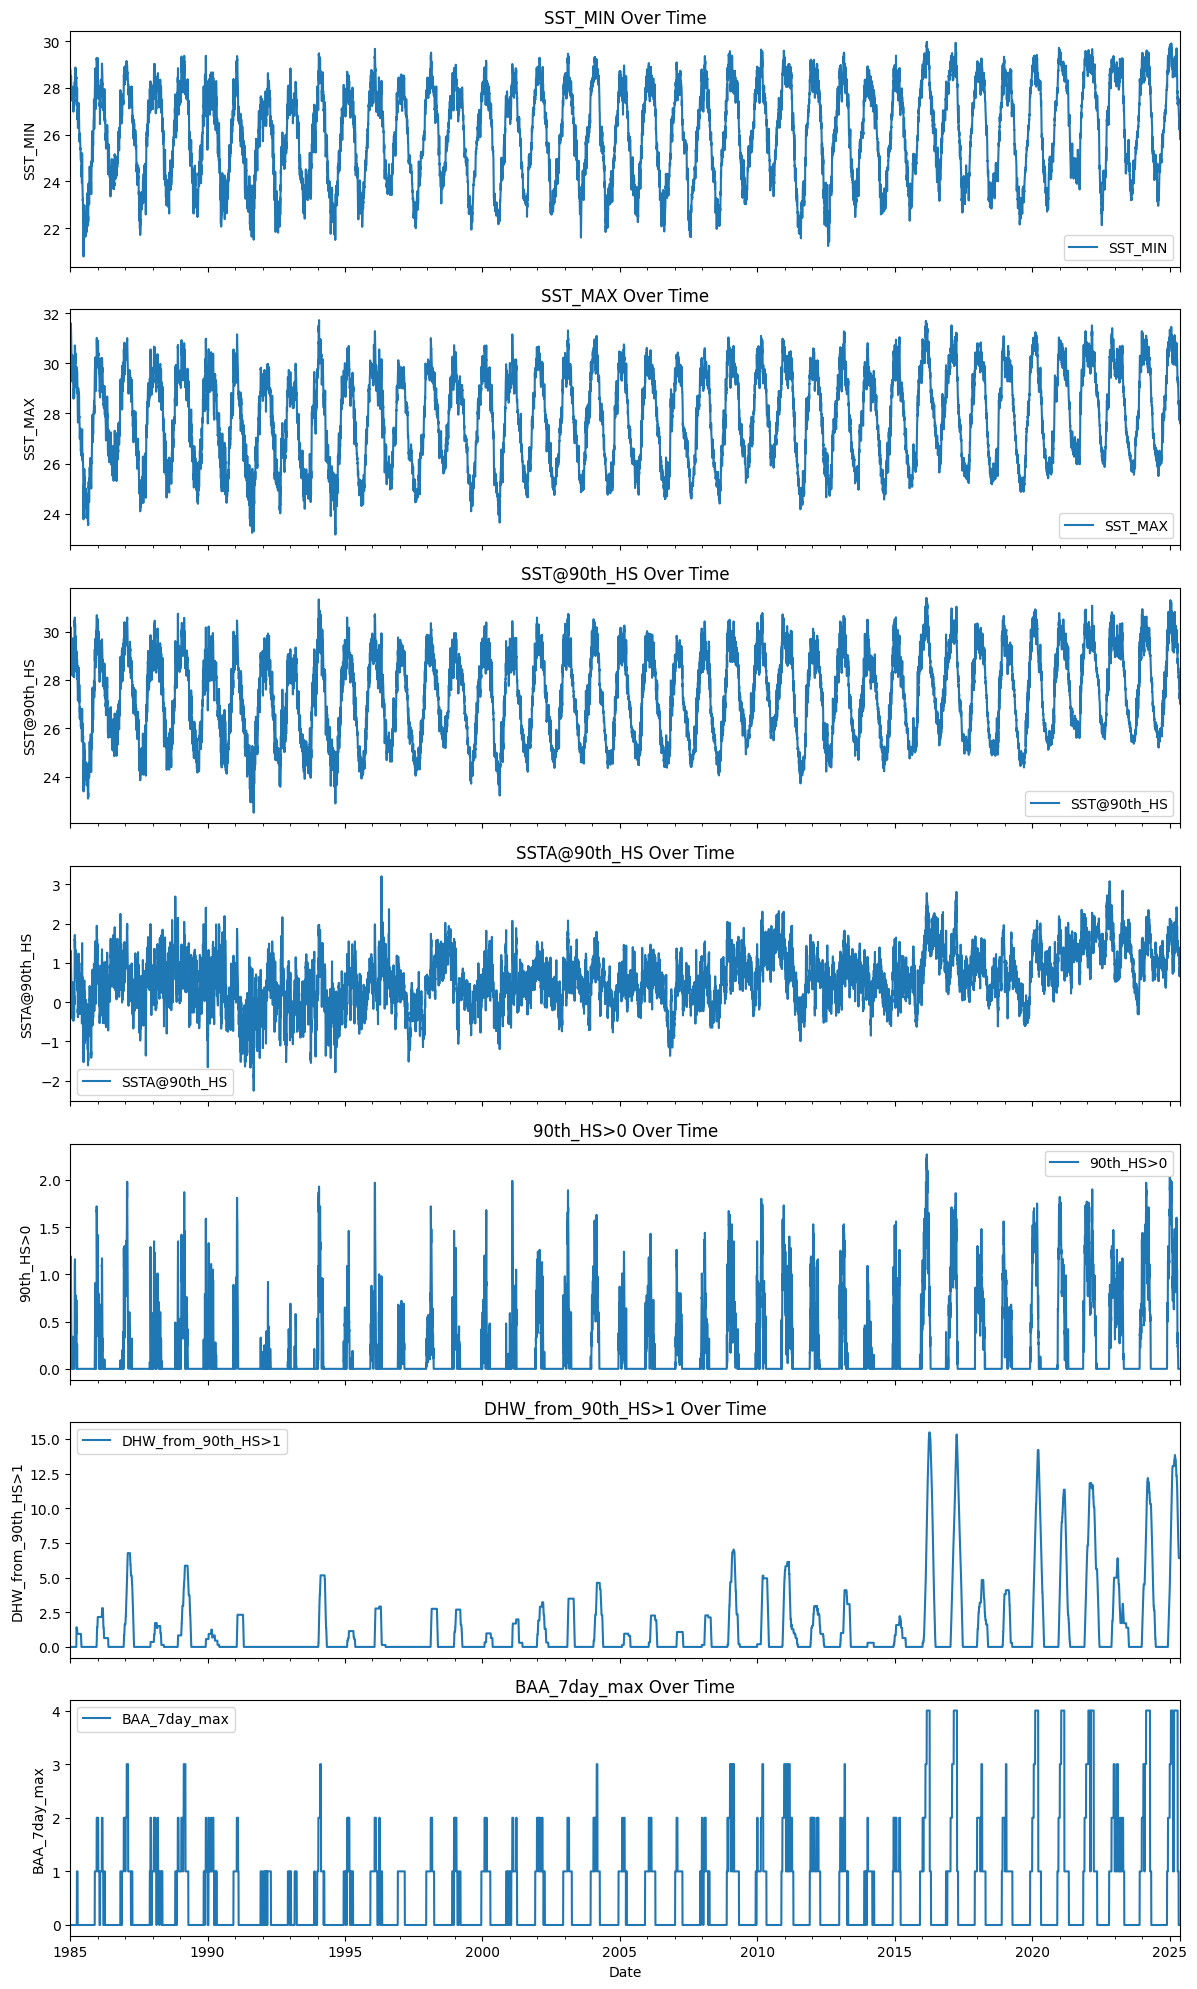

In [16]:
variables_to_plot = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 
                     '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']

fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(12, 20), sharex=True)

for i, var in enumerate(variables_to_plot):
    station_df.plot(x='Date', y=var, kind='line', ax=axes[i])
    axes[i].set_title(f'{var} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

Ok, we do seem to see some pattern across the SST anomalies here but it's a bit hard to directly look at multiple graphs at the same time and try to determine overlaps for pattern trends.

After a bit of research on how generic time-series analysis is done and digging through some online examples, we determined that we could use something called cross-correlation analysis here. 

A cross-corelation analysis can be used to measure the lagged relationships between two variables. What we mean by this is basically a check to see whether a change in one variable effects a change in another, and if so, how much time did it take. 

Lets take a look at the SST anomalies vs the bleaching severity first as we have had the most anticipation for those values:

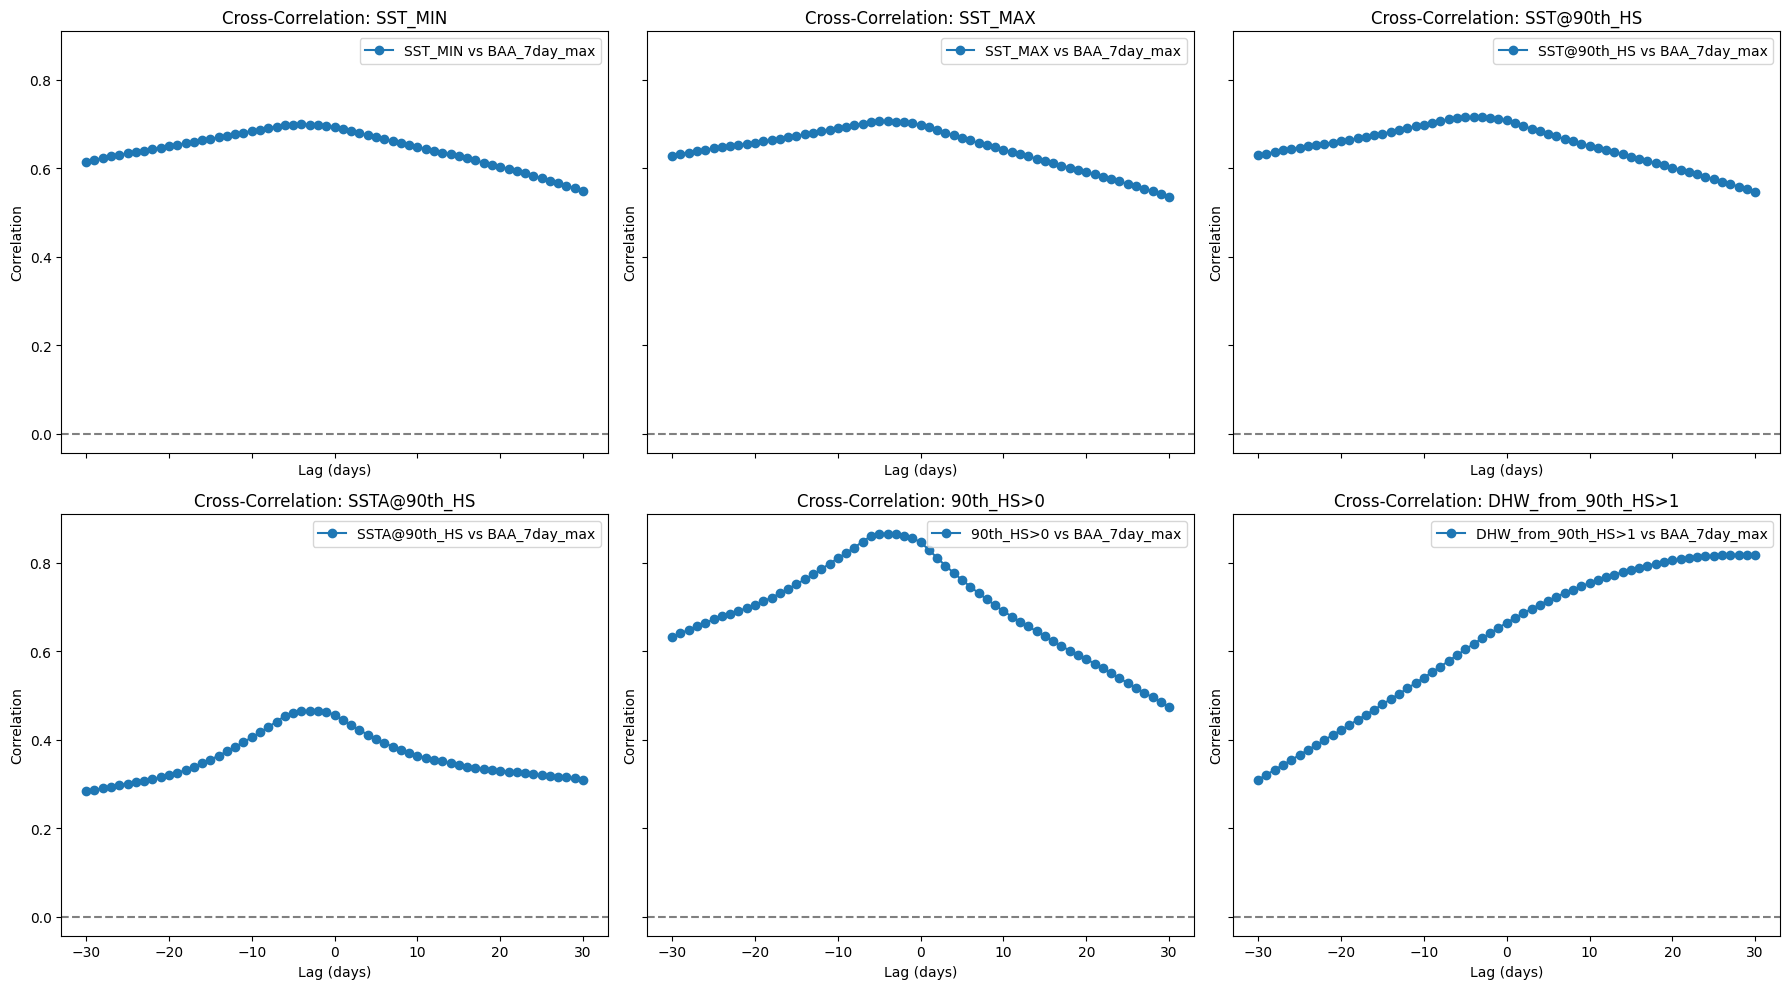

In [17]:
station_df = station_df.sort_values('Date')


variables = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1']

lags = np.arange(-30, 31)  # Test lags from -30 to +30 days
baa_7day_series = station_df['BAA_7day_max'].fillna(0)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(variables):
    series = station_df[var].fillna(0)
    cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
    
    axes[i].plot(lags, cross_corr, marker='o', label=f'{var} vs BAA_7day_max')
    axes[i].set_title(f'Cross-Correlation: {var}')
    axes[i].set_xlabel('Lag (days)')
    axes[i].set_ylabel('Correlation')
    axes[i].axhline(0, color='gray', linestyle='--')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [18]:
for var in variables:
    series = station_df[var].fillna(0)
    cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
    max_corr = max(cross_corr, key=abs)  
    optimal_lag = lags[cross_corr.index(max_corr)]
    print(f"Variable: {var}, Max Correlation: {max_corr:.3f}, Optimal Lag: {optimal_lag} days")

Variable: SST_MIN, Max Correlation: 0.699, Optimal Lag: -4 days
Variable: SST_MAX, Max Correlation: 0.706, Optimal Lag: -4 days
Variable: SST@90th_HS, Max Correlation: 0.716, Optimal Lag: -4 days
Variable: SSTA@90th_HS, Max Correlation: 0.465, Optimal Lag: -3 days
Variable: 90th_HS>0, Max Correlation: 0.866, Optimal Lag: -4 days
Variable: DHW_from_90th_HS>1, Max Correlation: 0.818, Optimal Lag: 28 days


TODO: Fill out:

Correlations:

The variable 90th_HS>0 showed the strongest positive correlation with bleaching severity (BAA_7day_max), confirming its importance as a predictor.
SST@90th_HS and SSTA@90th_HS also demonstrated significant correlations, indicating their relevance in understanding temperature anomalies and their impact on coral bleaching.
Distributions:

Variables like 90th_HS>0 and DHW_from_90th_HS>1 were heavily skewed, reflecting the rarity of extreme heat events.
SSTA@90th_HS exhibited a normal distribution, suggesting it captures stable and predictable temperature anomalies, making it a strong candidate for modeling.
Seasonal Analysis:

Seasonal patterns were evident in SST_MIN and SST_MAX, with bimodal distributions likely driven by seasonal changes.
Interestingly, SSTA@90th_HS appeared unaffected by seasonal variations, highlighting its potential as a robust feature for detecting unusual temperature events.
Time-Series Analysis:

Cross-correlation analysis revealed lagged relationships between variables like SSTA@90th_HS and BAA_7day_max, with optimal lags suggesting that temperature anomalies precede bleaching severity by a few days.
This insight can guide the inclusion of lagged variables in the supervised learning model to improve predictive accuracy.

## Multi-Set Analysis: Global Scale Analysis

We've done some comprehensive analysis on a single set, diving deeply into a specific station and drawing valuable conclusions that will come heavily into play for when we train the models. Let's now do part two of our EDA procedure and combine different datasets across different regions as our last step before model training in order to analyse coral bleaching factors at a global scale:

- Regional Analysis
- Validation of Single Set Station Findings
- Region Specific Insights
- Cluster on region basis
- Feature Engineering

In [19]:
all_stations_data = []

for url in urls:
    try:
        station_df = load_noaa_station_data(url)
        station_name = station_df['Station'].iloc[0]
        print(f"Loaded {station_name} with {len(station_df)} records")
        all_stations_data.append(station_df)
    except Exception as e:
        print(f"Error loading {url}: {str(e)}")


if all_stations_data:
    combined_regions_df = pd.concat(all_stations_data, ignore_index=True)
    
    create_noaa_date_column(combined_regions_df) # Create date column since we already know we need it
    
    numeric_cols = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 
                    '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']
    
    existing_numeric_cols = [col for col in numeric_cols if col in combined_regions_df.columns]
    
    for col in existing_numeric_cols:
        combined_regions_df[col] = pd.to_numeric(combined_regions_df[col], errors='coerce')
    
    create_noaa_seasonal_column(combined_regions_df) # Create seasonal column since we already know we need it
   
    combined_regions_df.to_csv('../../data/noaa/pulled_data/coral_reef_data_combined.csv', index=False)
    print("\nCombined dataset saved to 'coral_reef_data_combined.csv'")
else:
    print("no stations loaded.")

Loaded Far Northern GBR with 14752 records
Loaded Torres Strait with 14750 records
Loaded Northern GBR with 14752 records
Loaded Samoas with 14751 records
Loaded Main Hawaiian Islands with 14752 records
Loaded Southern Cook Islands with 14750 records
Loaded Nicaragua with 14752 records
Loaded Panama Atlantic East with 14752 records
Loaded Jamaica with 14752 records
Loaded Kerala, India with 14752 records
Loaded Eastern Sri Lanka with 14752 records
Loaded Gulf of Kutch, India with 14752 records

Combined dataset saved to 'coral_reef_data_combined.csv'


### Regional Analysis

In [20]:
print(f"Total number of records: {len(combined_regions_df)}")
print(f"Columns in the combined dataset: {combined_regions_df.head()}")

Total number of records: 177019
Columns in the combined dataset:    YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  90th_HS>0  \
0  1985  01  01    28.82    29.25        29.03        0.7797       0.56   
1  1985  01  02    28.80    29.33        29.02        0.7135       0.55   
2  1985  01  03    28.80    29.27        29.03        0.7219       0.49   
3  1985  01  04    28.75    29.31        29.03        0.7103       0.46   
4  1985  01  05    28.71    30.67        29.64        1.3177       1.05   

   DHW_from_90th_HS>1  BAA_7day_max           Station              Region  \
0                 0.0             0  Far Northern GBR  Great Barrier Reef   
1                 0.0             0  Far Northern GBR  Great Barrier Reef   
2                 0.0             0  Far Northern GBR  Great Barrier Reef   
3                 0.0             0  Far Northern GBR  Great Barrier Reef   
4                 0.0             0  Far Northern GBR  Great Barrier Reef   

   Latitude  Longitud

In [27]:
print('duplicate rows: ',  combined_regions_df.duplicated().sum())
print(combined_regions_df.isna().sum()) 
print(combined_regions_df.dtypes)

duplicate rows:  0
YYYY                  0
MM                    0
DD                    0
SST_MIN               0
SST_MAX               0
SST@90th_HS           0
SSTA@90th_HS          0
90th_HS>0             0
DHW_from_90th_HS>1    0
BAA_7day_max          0
Station               0
Region                0
Latitude              0
Longitude             0
Date                  0
Season                0
dtype: int64
YYYY                          object
MM                            object
DD                            object
SST_MIN                      float64
SST_MAX                      float64
SST@90th_HS                  float64
SSTA@90th_HS                 float64
90th_HS>0                    float64
DHW_from_90th_HS>1           float64
BAA_7day_max                   int64
Station                       object
Region                        object
Latitude                     float64
Longitude                    float64
Date                  datetime64[ns]
Season                       

Datasets checks out with no null values and a clean record of no duplicated rows either.

Lets try grouping by region next and start seeing some information on the dataset that we just combined:

In [24]:
regional_summary = combined_regions_df.groupby('Region')[numeric_cols].describe()
print(regional_summary)

                    SST_MIN                                                   \
                      count       mean       std    min    25%    50%    75%   
Region                                                                         
Caribbean           44256.0  27.653562  0.925315  24.28  26.96  27.66  28.34   
Great Barrier Reef  44254.0  26.223437  2.000825  20.38  24.67  26.48  27.94   
Polynesia           44253.0  26.118494  1.945997  21.44  24.40  26.03  27.83   
South Asia          44256.0  27.143163  2.259276  17.09  26.48  27.70  28.61   

                           SST_MAX             ... DHW_from_90th_HS>1  \
                      max    count       mean  ...                75%   
Region                                         ...                      
Caribbean           30.66  44256.0  28.587684  ...             0.7886   
Great Barrier Reef  30.41  44254.0  27.806839  ...             1.1043   
Polynesia           30.68  44253.0  27.740174  ...             0.1443   
S

The first thing that we noticed here is the incredibly low BAA_7day_max_mean for the south asia region in comparison to the Caribbean region. The reason for why we find this rather strange is because we expect the bleaching levels to be much higher on average within the south asia region. 

I hypothesis that the data is likely skewed due the high severity levels in the South Asia region which is causing the mean to become much lower in comparison to the caribbean region.

Either way, lets make a start and visualise some distributions so that we can take a better look into the distributions of the different regions

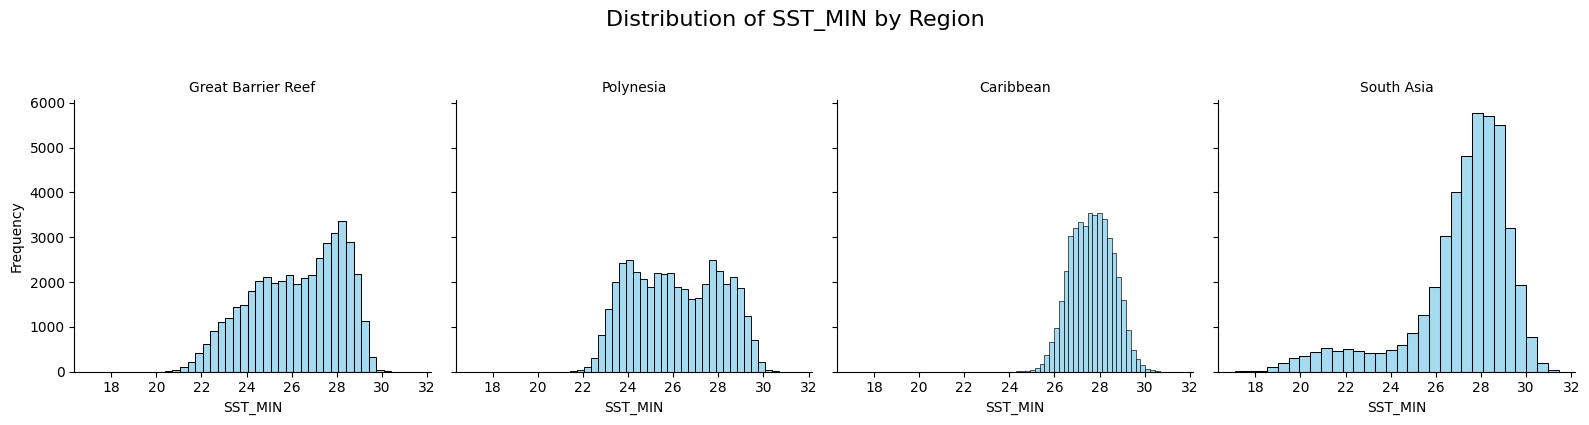

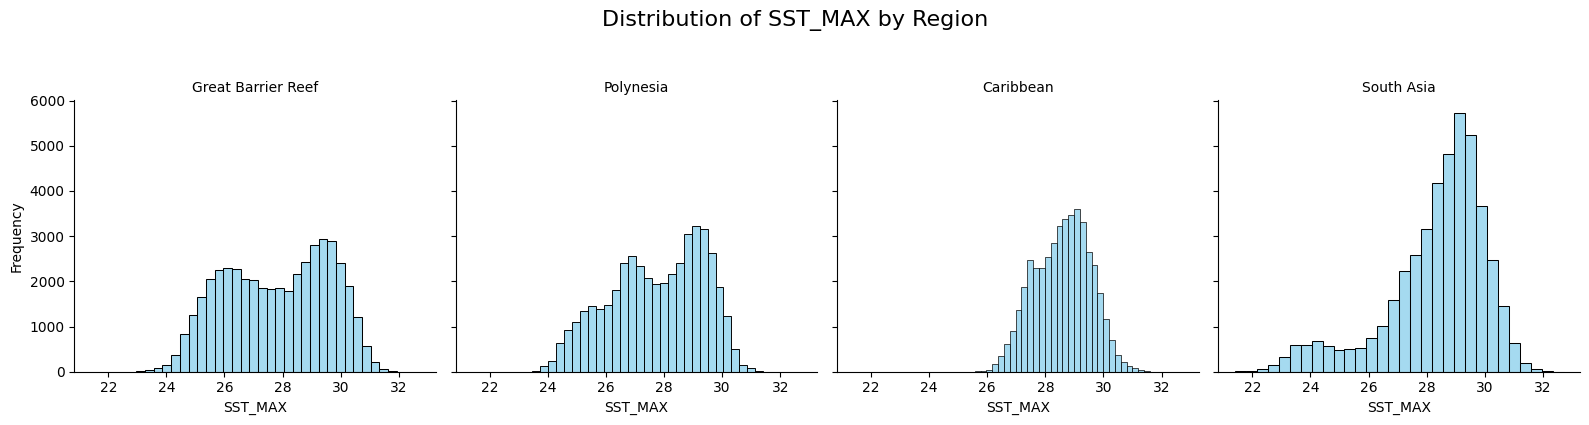

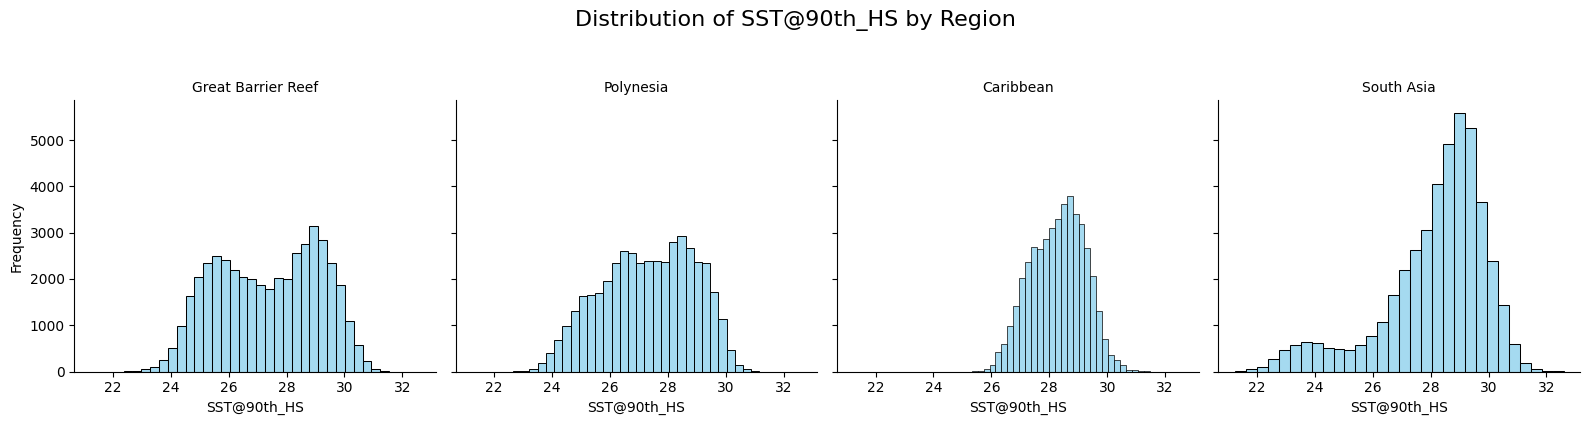

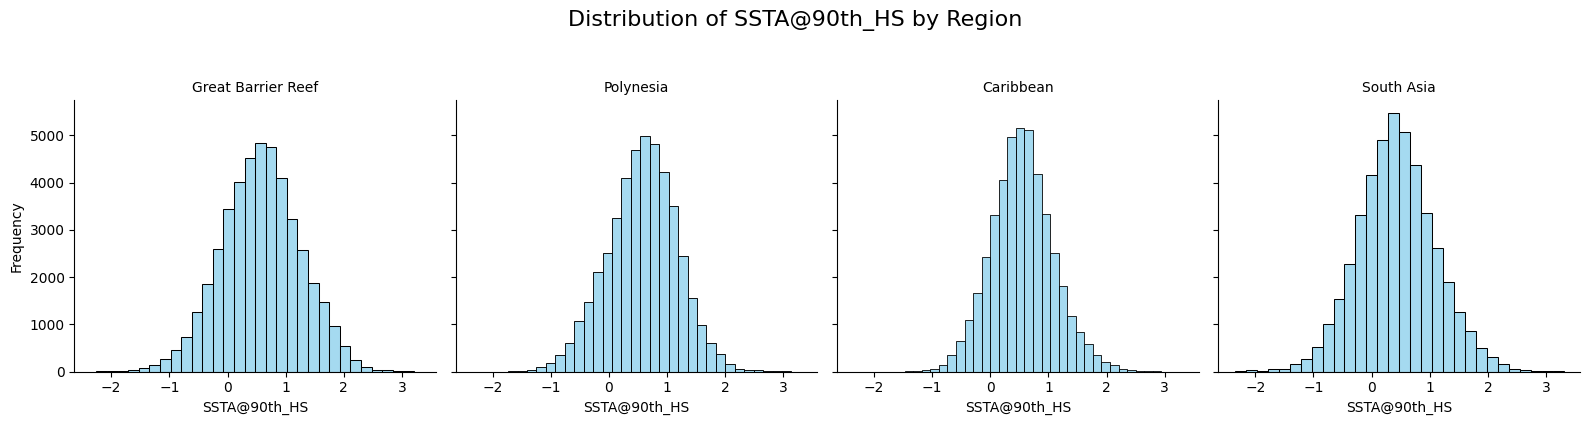

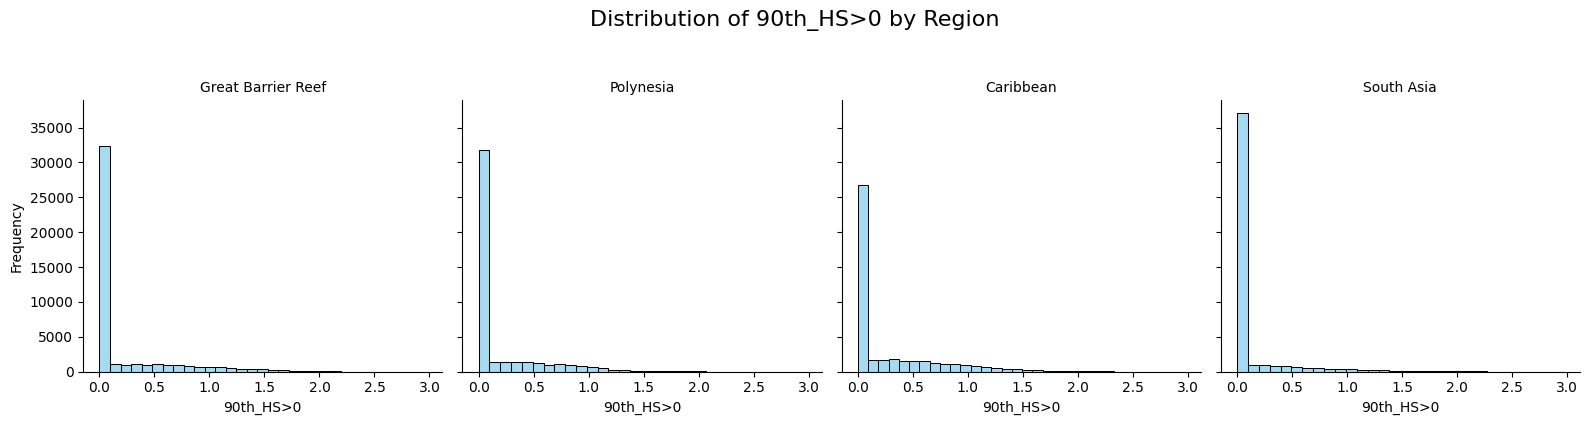

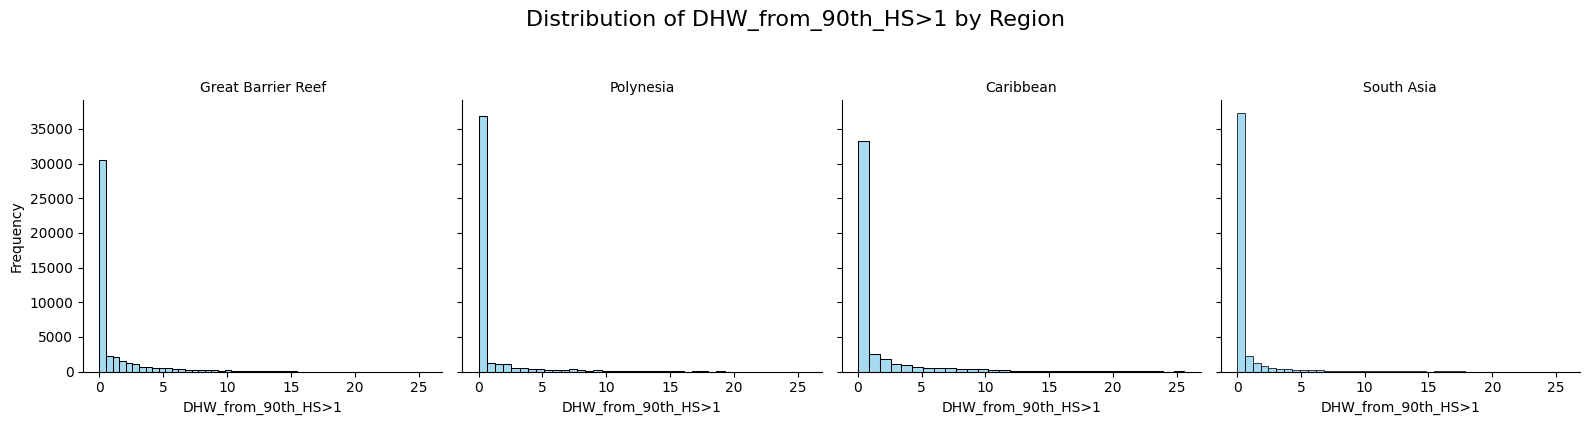

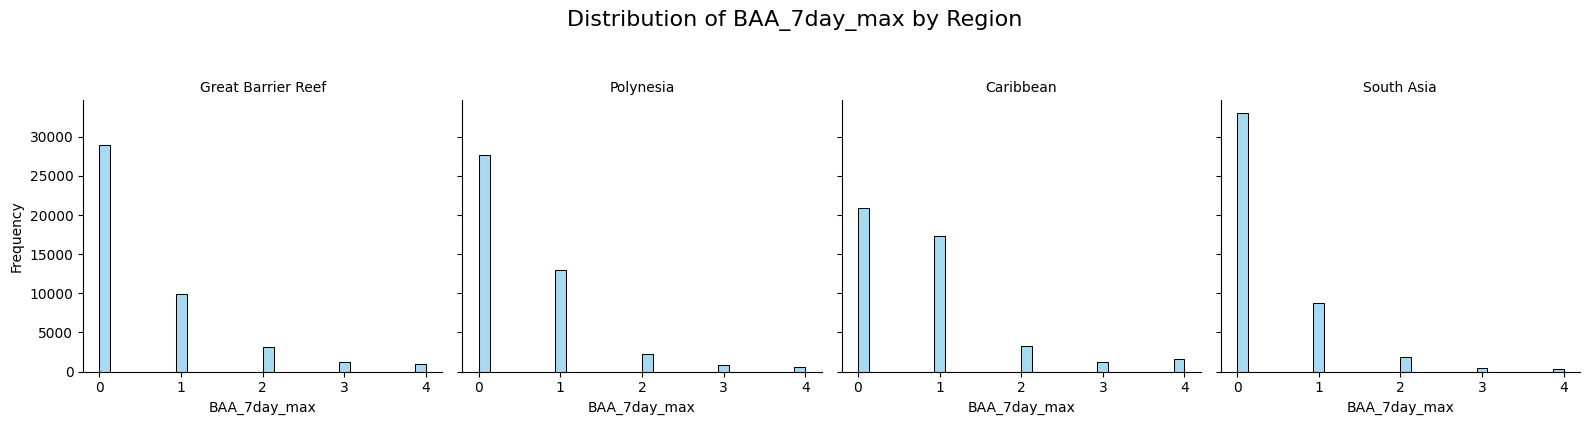

In [43]:
for col in numeric_cols:
    # Create a FacetGrid for the current column
    g = sns.FacetGrid(combined_regions_df, col="Region", col_wrap=4, sharex=True, sharey=True, height=4)
    g.map(sns.histplot, col, bins=30, kde=False, color="skyblue")
    
    # Add titles and labels
    g.set_titles("{col_name}")
    g.set_axis_labels(col, "Frequency")
    g.fig.suptitle(f"Distribution of {col} by Region", y=1.05, fontsize=16)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

We can see quite clearly that the south asia region has incrediby higher levels of SST fluctuations compared to the caribbean region. In fact, there is some much of a difference that between the SST's where the Carribean distribution shows an almost normal distribution consistently between the three SST columns showing showing as very stable and gradual levels of fluctuations. This makes us start to question and think that the temperature fluctuations between seasons might generally be a very big influencer to the bleaching levels of corals across different regions.

We should further confirm our hypothesis by looking into the seasonal, but first lets take an intermediate step and quickly take a look at a correlations between the different values on a global scale between the different regions and see whether we can spot any differences.

### Correlations

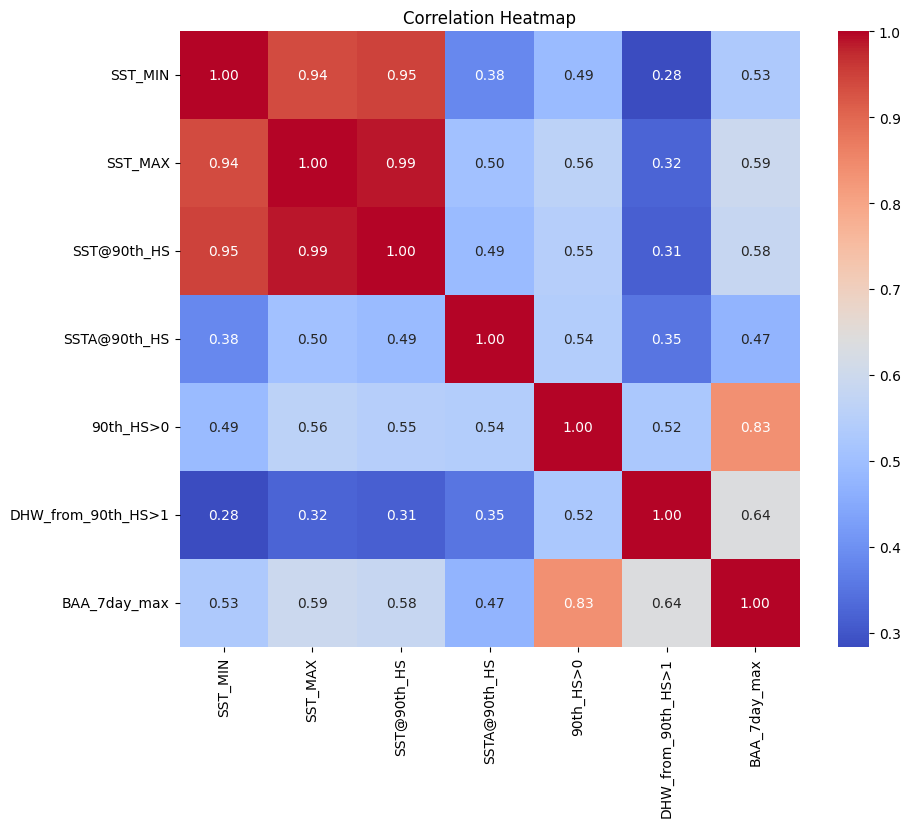

In [34]:
correlation_matrix = combined_regions_df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

The correlation heat map shows almost identical results to out single set analysis for the correlations between the datapoints. This is great to know as it tells us that the dataset ir reliable and our findings to begin with during the first part of our EDA was along the right lines.

Now that we have the multi-regional combined dataset, we can do the seasonal analysis at a larger scale for the combined dataset. Hopefully from a larger multi regional and station scale, this time we will see seasonal trends across all the regions at once and draw a better picture for us to determine with effect that the seasonal changes have on corals at a much larger scale. 

Let's take a look:

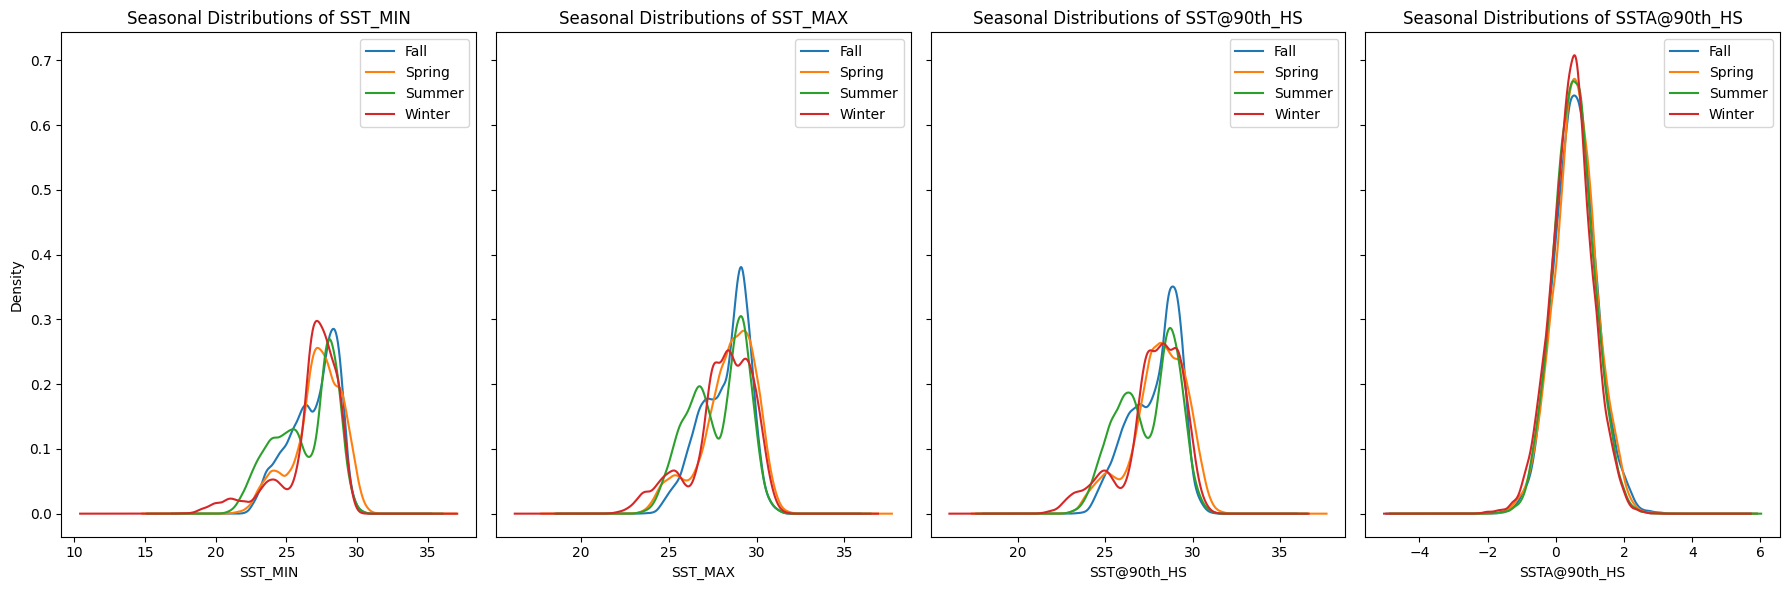

In [51]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

# For SST_MIN
combined_regions_df.groupby('Season')['SST_MIN'].plot(kind='kde', ax=axes[0], legend=True)
axes[0].set_title('Seasonal Distributions of SST_MIN')
axes[0].set_xlabel('SST_MIN')

# For SST_MAX
combined_regions_df.groupby('Season')['SST_MAX'].plot(kind='kde', ax=axes[1], legend=True)
axes[1].set_title('Seasonal Distributions of SST_MAX')
axes[1].set_xlabel('SST_MAX')

# For SST@90th_HS
combined_regions_df.groupby('Season')['SST@90th_HS'].plot(kind='kde', ax=axes[2], legend=True)
axes[2].set_title('Seasonal Distributions of SST@90th_HS')
axes[2].set_xlabel('SST@90th_HS')

# For SSTA@90th_HS

combined_regions_df.groupby('Season')['SSTA@90th_HS'].plot(kind='kde', ax=axes[3], legend=True)
axes[3].set_title('Seasonal Distributions of SSTA@90th_HS')
axes[3].set_xlabel('SSTA@90th_HS')

plt.tight_layout()
plt.show()

Again, further confirmation of our earlier findings. We can clearly see that across the seasonal fluctuations of the combined dataset, the dominant seasonsal fluctuation for the SST is in the Fall season. This tells us that the Fall season is most likely much more prone to some SST conditions that leads to coral bleaching.

Coming this far, I think that it is safe to say the the relationship between coral bleaching and SST might very likely be non-linear. This has made the project even more exciting but challenging at the same time. To clarify what we are questioning now, lets do some testing and find out.

### Non-Linear Relationships


First lets just look at the SSTA. Why? Because the SSTA represents actual deviations from the long-term average of the SST. If we recall our events from earlier, we managed to determine that the SSTA is NOT effected by seasonal fluctuations. The last graph in the seaonsal distributions above, representing the SSTA, just proves it showing a normal distribution across all the regions. This should make it the ultimate tool for us to identify extreme events.

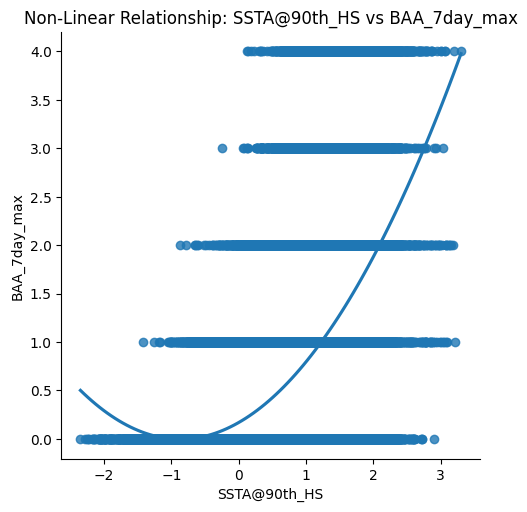

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.lmplot.html
sns.lmplot(data=combined_regions_df, x='SSTA@90th_HS', y='BAA_7day_max', order=2, ci=None)
plt.title('Non-Linear Relationship: SSTA@90th_HS vs BAA_7day_max')
plt.show()

This confirms our hypothesis on it being a non-linear relationship. We seem to be witnessing a quadratic shaped curve where the vertex of the curve seems to sit at the value around -0.8 is our guess. What this directly translates too is that the severity level of the coral bleaching seems to actually increase at an exponential rate once passing an SSTA value of 0#

Let's take a further look for all values and take this opportunity to graph the relationships for each column individually, each in comparison to investigate their relationships with the BAA

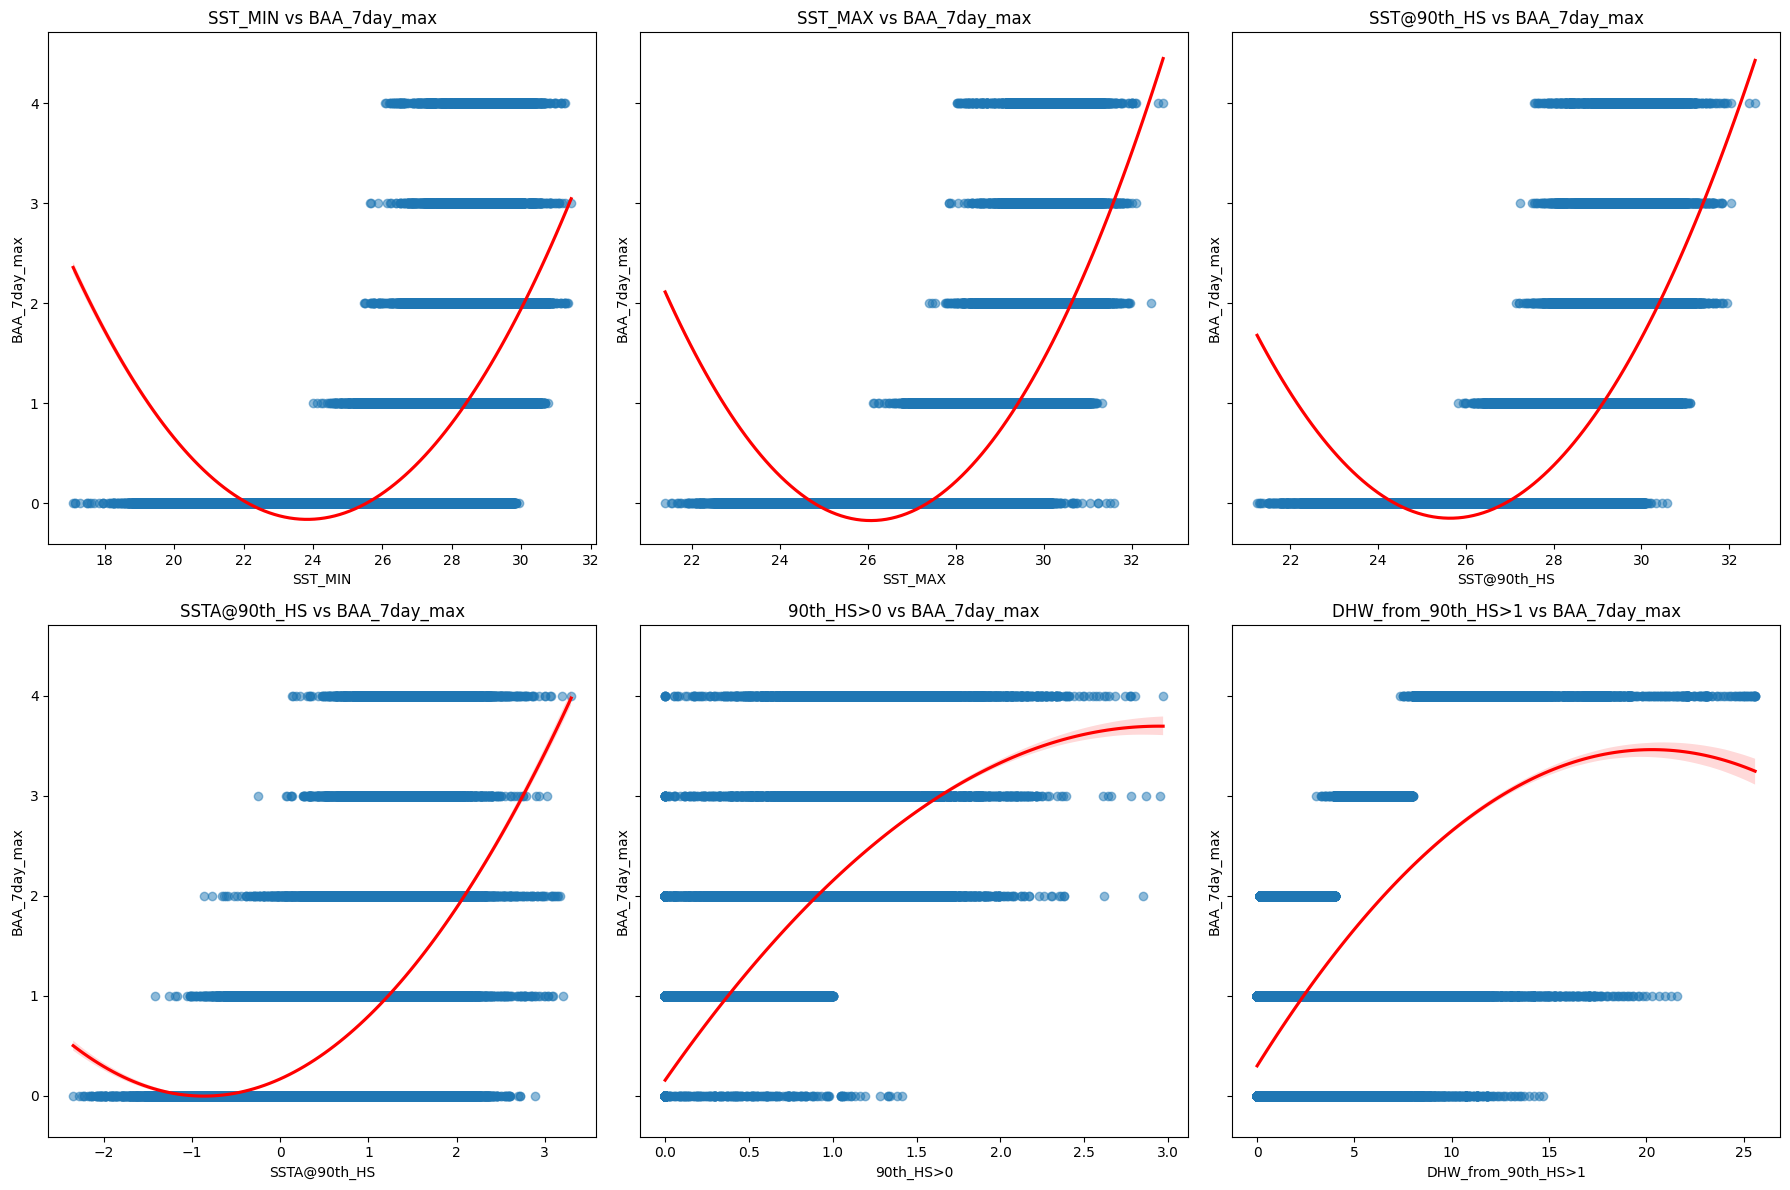

In [55]:
variables_to_test = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1']

fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

axes = axes.flatten()

for i, var in enumerate(variables_to_test):
    sns.regplot(
        data=combined_regions_df,
        x=var,
        y='BAA_7day_max',
        order=2,
        ax=axes[i],
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'}
    )
    axes[i].set_title(f'{var} vs BAA_7day_max')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('BAA_7day_max')

plt.tight_layout()
plt.show()

TODO: Ken to fill on further analysis especially around the 90th percentile hotspots and th DHW

### Time-series Analysis

Same as before, sort the set by date:

In [56]:
combined_regions_df = combined_regions_df.sort_values('Date')

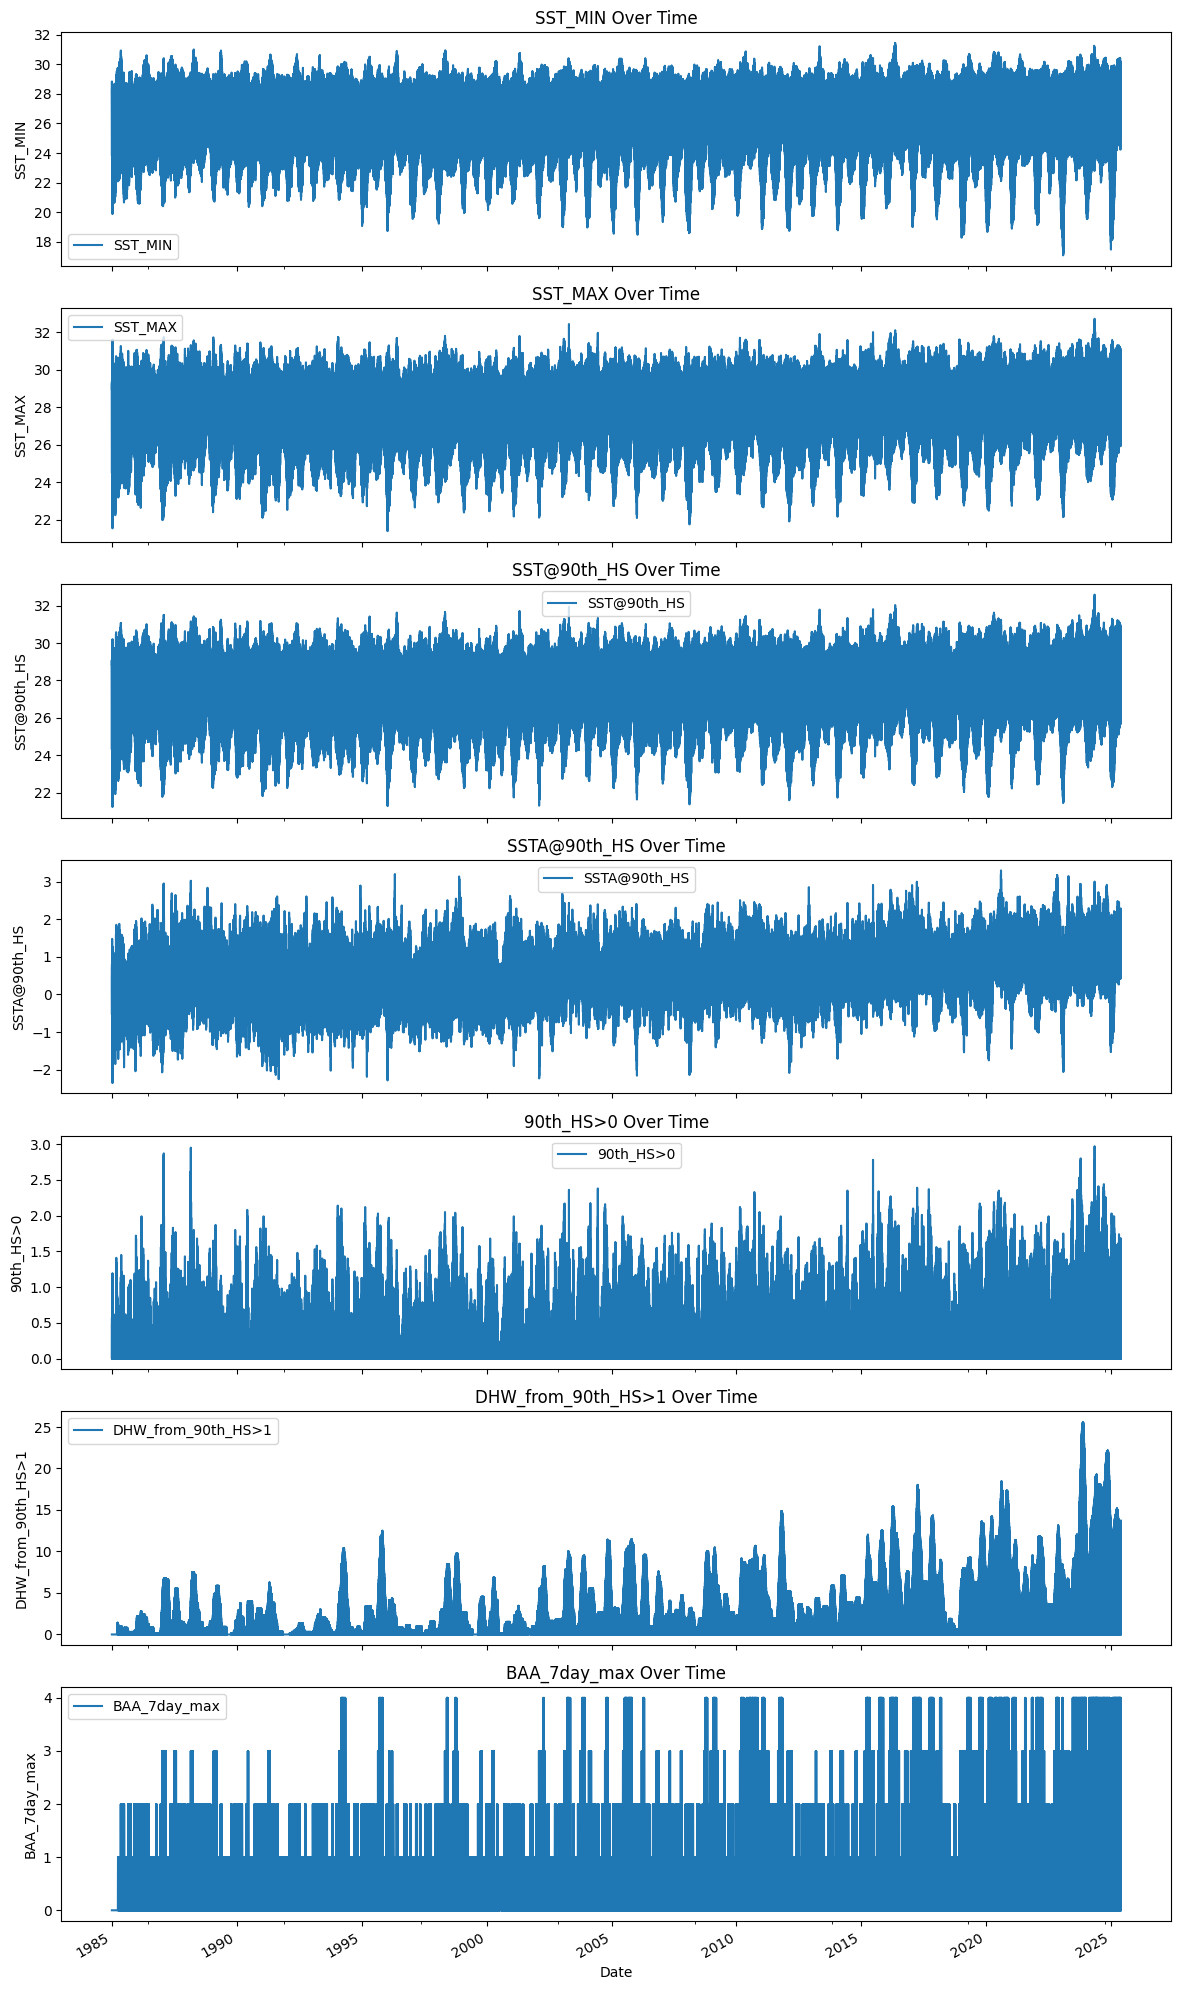

In [ ]:
variables_to_plot = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']

fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(12, 20), sharex=True)

for i, var in enumerate(variables_to_plot):
    combined_regions_df.plot(x='Date', y=var, kind='line', ax=axes[i])
    axes[i].set_title(f'{var} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

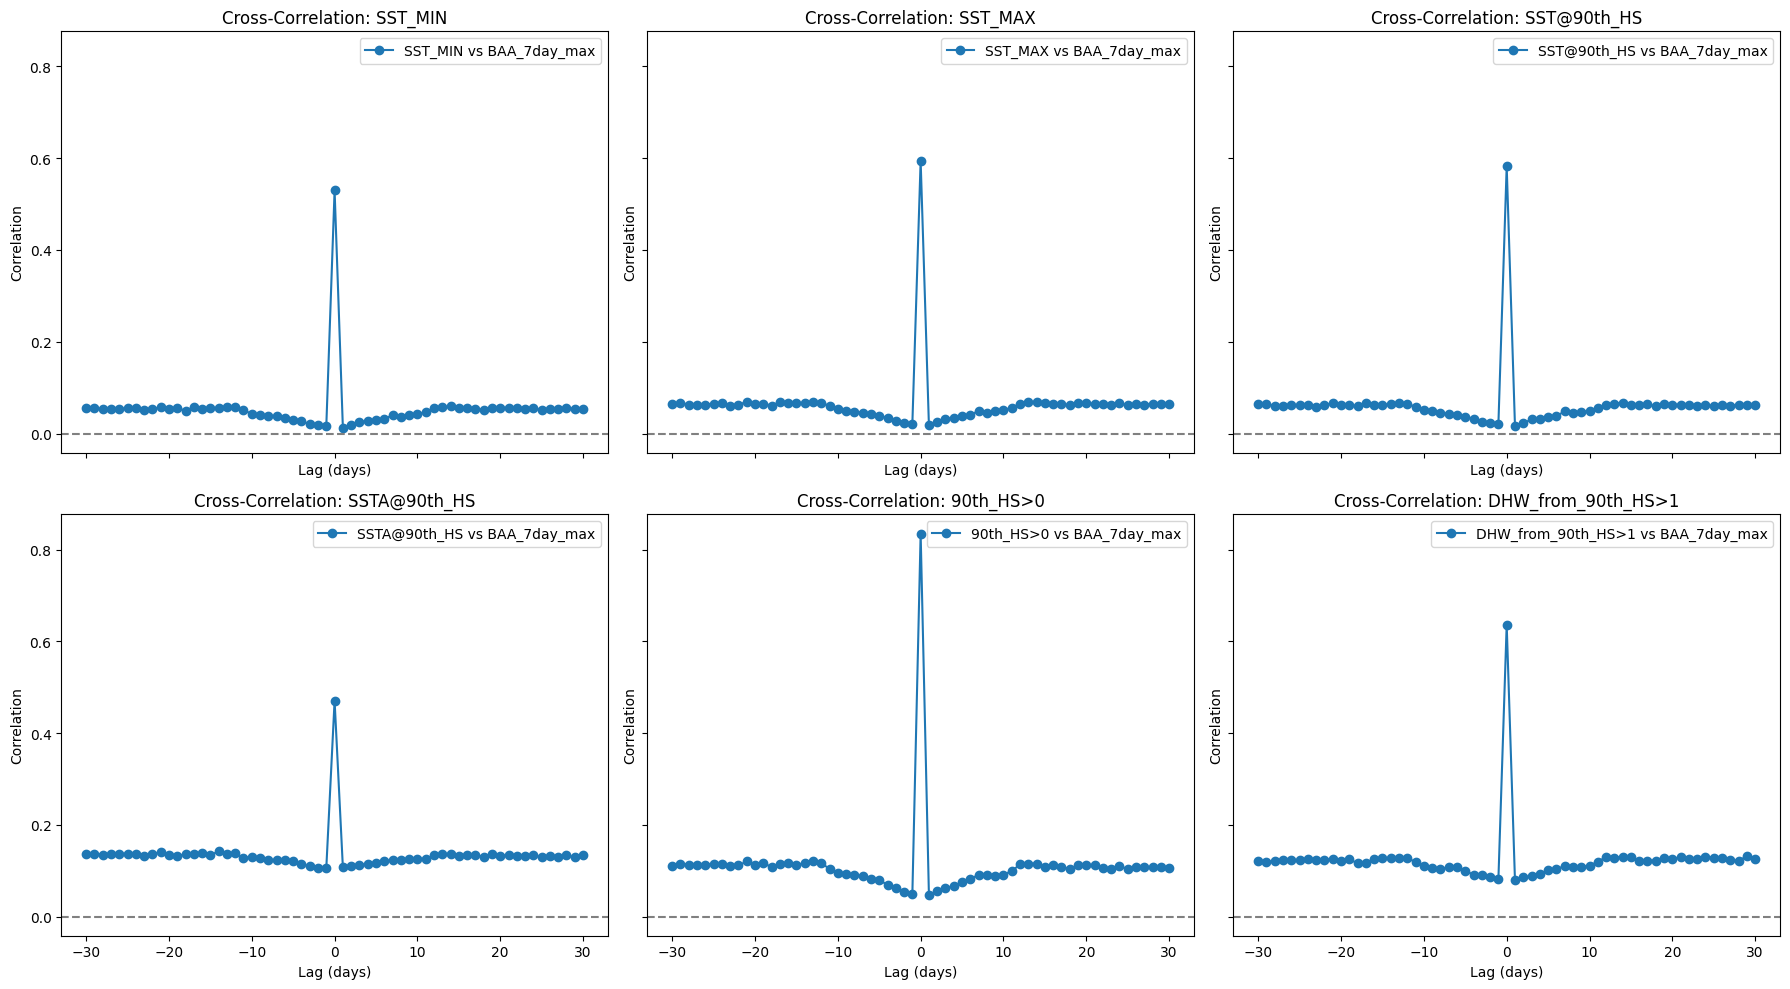

In [61]:
variables = ['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1']

lags = np.arange(-30, 31)  # Test lags from -30 to +30 days
baa_7day_series = combined_regions_df['BAA_7day_max'].fillna(0)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, var in enumerate(variables):
    series = combined_regions_df[var].fillna(0)
    cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
    
    axes[i].plot(lags, cross_corr, marker='o', label=f'{var} vs BAA_7day_max')
    axes[i].set_title(f'Cross-Correlation: {var}')
    axes[i].set_xlabel('Lag (days)')
    axes[i].set_ylabel('Correlation')
    axes[i].axhline(0, color='gray', linestyle='--')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
for var in variables:
    series = station_df[var].fillna(0)
    cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
    max_corr = max(cross_corr, key=abs)  
    optimal_lag = lags[cross_corr.indexma(x_corr)]
    print(f"Variable: {var}, Max Correlation: {max_corr:.3f}, Optimal Lag: {optimal_lag} days")

Variable: SST_MIN, Max Correlation: -0.669, Optimal Lag: 0 days
Variable: SST_MAX, Max Correlation: -0.641, Optimal Lag: 0 days
Variable: SST@90th_HS, Max Correlation: -0.653, Optimal Lag: 0 days
Variable: SSTA@90th_HS, Max Correlation: -0.251, Optimal Lag: 0 days
Variable: 90th_HS>0, Max Correlation: -0.238, Optimal Lag: 0 days
Variable: DHW_from_90th_HS>1, Max Correlation: -0.225, Optimal Lag: 0 days


Well the 0 log here for all the cross-corelation can likely be explained by the regional difference, and the time zones. The only way to further determine this would be to break down the cross correlation by station instead and try to find them individually so that they are not effecting by the time zones:

In [64]:
stations = combined_regions_df['Station'].unique()

for station in stations:
    station_df = combined_regions_df[combined_regions_df['Station'] == station]
    baa_7day_series = station_df['BAA_7day_max'].fillna(0)
    
    print(f"Station: {station}")
    for var in variables:
        series = station_df[var].fillna(0)
        cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
        max_corr = max(cross_corr, key=abs)
        optimal_lag = lags[cross_corr.index(max_corr)]
        print(f"  Variable: {var}, Max Correlation: {max_corr:.3f}, Optimal Lag: {optimal_lag} days")

Station: Far Northern GBR
  Variable: SST_MIN, Max Correlation: 0.699, Optimal Lag: -4 days
  Variable: SST_MAX, Max Correlation: 0.706, Optimal Lag: -4 days
  Variable: SST@90th_HS, Max Correlation: 0.716, Optimal Lag: -4 days
  Variable: SSTA@90th_HS, Max Correlation: 0.465, Optimal Lag: -3 days
  Variable: 90th_HS>0, Max Correlation: 0.866, Optimal Lag: -4 days
  Variable: DHW_from_90th_HS>1, Max Correlation: 0.818, Optimal Lag: 28 days
Station: Northern GBR
  Variable: SST_MIN, Max Correlation: 0.652, Optimal Lag: -4 days
  Variable: SST_MAX, Max Correlation: 0.698, Optimal Lag: -4 days
  Variable: SST@90th_HS, Max Correlation: 0.698, Optimal Lag: -3 days
  Variable: SSTA@90th_HS, Max Correlation: 0.427, Optimal Lag: -3 days
  Variable: 90th_HS>0, Max Correlation: 0.851, Optimal Lag: -4 days
  Variable: DHW_from_90th_HS>1, Max Correlation: 0.786, Optimal Lag: 30 days
Station: Samoas
  Variable: SST_MIN, Max Correlation: 0.762, Optimal Lag: -3 days
  Variable: SST_MAX, Max Correlati

If we take the averages, we can get this into some more valuable parts as we can see the average time lags across each of the columns:

In [65]:
results = {var: {'avg_corr': [], 'avg_lag': []} for var in variables}

for station in stations:
    station_df = combined_regions_df[combined_regions_df['Station'] == station]
    baa_7day_series = station_df['BAA_7day_max'].fillna(0)
    
    for var in variables:
        series = station_df[var].fillna(0)
        cross_corr = [series.corr(baa_7day_series.shift(lag)) for lag in lags]
        max_corr = max(cross_corr, key=abs)
        optimal_lag = lags[cross_corr.index(max_corr)]
        
        results[var]['avg_corr'].append(max_corr)
        results[var]['avg_lag'].append(optimal_lag)

averages = {var: {'avg_corr': np.mean(results[var]['avg_corr']),
                  'avg_lag': np.mean(results[var]['avg_lag'])} for var in variables}

for var, stats in averages.items():
    print(f"Variable: {var}, Average Correlation: {stats['avg_corr']:.3f}, Average Lag: {stats['avg_lag']:.1f} days")

Variable: SST_MIN, Average Correlation: 0.702, Average Lag: -3.6 days
Variable: SST_MAX, Average Correlation: 0.715, Average Lag: -3.7 days
Variable: SST@90th_HS, Average Correlation: 0.717, Average Lag: -3.5 days
Variable: SSTA@90th_HS, Average Correlation: 0.473, Average Lag: -3.2 days
Variable: 90th_HS>0, Average Correlation: 0.834, Average Lag: -4.2 days
Variable: DHW_from_90th_HS>1, Average Correlation: 0.741, Average Lag: 29.0 days


TODO: Ken to fill analysis

## Feature Engineering

Before we continue onto further steps of feature engineering then model testing & selection, let's take a step back and recap on our findings so far. 

We have managed to determine:
- We've had a look into corrleations and what the strong predictors are. This turned out to be the 90th_HS>0, and the DHW_from_90th_HS>1 values.

- Time lagged relationships between the different columns and the bleaching levels. This is crucial to feed the model as it helps the model understand how certain values can be seen as early warning signs and that the pinpointing the time lag will actually help the model understand bleaching risks from an earlier stage and possibly make forecasts, potentially opening us up to the ARIA model domain 

- Most importantly, we also confirmed that we are working in a Non-linear space where passing certain SST & SSTA thresholds can cause growth in bleaching severity at an exponential rate.

- Threshold values. In relation to the previous point of defining a non-linear space, it's important to note and target certain values that we can treat as thresholds since we understand that passing these values will cause exponential increases in bleach risks

- Last but not least: Seasonal Patterns. We managed to determine that changes in the season caused fluctuations in SST and when we particularly looked into the seasonal analysis between both the single set, and multi-set evaluations, it was apparent that the seasonal patterns also played a role in our SST fluctuations which we could relate to the BAA changes


Considering all of these points, we have decided to move forward with creating 5 new features:

- Lagged features for catering time lags

- Threshold features for determining key threshold values points

- Polynomial Features?

- Interaction terms?

### Feature 1 <> Lagged Features

Values: SST_MIN_lag4, SST_MAX_lag4, SST@90th_HS_lag4, SSTA@90th_HS_lag4, 90th_HS>0_lag4, DHW_from_90th_HS>1_lag29

Description: This feature represents the time lag values for all the values where we computed the mean lag days and round them to the nearest integer.

Reasoning:
- Including lagged features helps the model understand how past values and influence current bleaching severity.

In [71]:
combined_regions_df['SST_MIN_lag_back_4'] = combined_regions_df['SST_MIN'].shift(-4)
combined_regions_df['SST_MAX_lag_back_4'] = combined_regions_df['SST_MAX'].shift(-4)
combined_regions_df['SST@90th_HS_lag_back_4'] = combined_regions_df['SST@90th_HS'].shift(-4)
combined_regions_df['SSTA@90th_HS_lag_back_3'] = combined_regions_df['SSTA@90th_HS'].shift(-3)
combined_regions_df['90th_HS>0_lag_back_4'] = combined_regions_df['90th_HS>0'].shift(-4)
combined_regions_df['DHW_from_90th_HS>1_lag_forward_29'] = combined_regions_df['DHW_from_90th_HS>1'].shift(29)

### Feature 2 <> Threshold Features

Values: SSTA_above_threshold, 90th_HS_above_threshold

Description: A binary feature indicating whether SSTA@90th_HS exceeds 0 (i.e., whether the anomaly is positive) & when the 90th_HS>0 above 0/hit.

Reasoning:
- Crossing certain thresholds (e.g., SSTA@90th_HS > 0) is critical for identifying extreme temperature events that may lead to coral bleaching.

- This feature simplifies the model's ability to detect such events by converting continuous values into a binary indicator.

In [68]:
combined_regions_df['SSTA_above_threshold'] = (combined_regions_df['SSTA@90th_HS'] > 0).astype(int)
combined_regions_df['90th_HS_above_0'] = (combined_regions_df['90th_HS>0'] > 0).astype(int)

### Feature 3 <> Polynomial Features

Values: SSTA_squared

Description: The square of SSTA@90th_HS for capturing the non-linear relationship

Reasoning:
- The relationship between SSTA@90th_HS and BAA_7day_max was observed to be non-linear (quadratic).

- Adding a squared term allows the model to capture this non-linear relationship more effectively.

In [67]:
combined_regions_df['SSTA_squared'] = combined_regions_df['SSTA@90th_HS'] ** 2

### Feature 4 <> Interaction Term

Values: SSTA_DHW_interaction

Description: Where we multiply the SSTA@90th_HS and DHW_from_90th_HS>1

Reasoning:
- Interaction terms capture the combined effect of two variables.

- For example, the interaction between temperature anomalies (SSTA@90th_HS) and accumulated heat stress (DHW_from_90th_HS>1) may provide additional predictive power for bleaching severity.

In [70]:
combined_regions_df['SSTA_DHW_interaction'] = combined_regions_df['SSTA@90th_HS'] * combined_regions_df['DHW_from_90th_HS>1']

# Model Training